# EE769 Introduction to Machine Learning
## Course Project : Rendering natural camera bokeh effect with deep learning

### Problem Statement: 
Implement the convolutional neural network model described in the paper "Rendering Natural Camera Bokeh Effect with Deep Learning" - http://dx.doi.org/10.1109/CVPRW50498.2020.00217 for applying bokeh effect on images and deploy the model as a web application

### Motivation: 
Bokeh is an important artistic effect used to highlight the main object of interest on the photo by blurring all out-of focus areas. While DSLR and system camera lenses can render this effect naturally, mobile cameras are unable to produce shallow depth-of-field photos due to a very small aperture diameter of their optics. 

### Implementation: 
Bokeh effect simulation problem belongs to a group of tasks dealing with both global and local image processing. High-level image analysis is needed here to detect the areas on the photo where the bokeh effect should be applied, whereas low-level processing is used for rendering the actual shallow depth-of-field images and refining the results. A model specifically designed for this purpose is PyNET. It is designed to processing image at different scales and combining the learned global and local features together.

### PyNET CNN Architecture:
![<caption>](pynet.png)
The above figure illustrates schematic representation of the PyNET architecture that is used in this project. The model has an inverted pyramidal shape and is processing image at seven different levels. The PyNET-based model architecture includes parallel processing of feature maps with different convolutional filter sizes, concatenation and summation operations on adjacent layers, and the use of transposed convolutional layers for upsampling. The model is trained sequentially from the lowest layer and then applied to the next level until training is done on the original resolution. The model mainly learns to reconstruct missing low-level details and refine the results. The resolution of the produced images is twice higher than the input data size, which increases training and inference speed. Sample visual results show the effectiveness of the proposed deep learning method.
##### Specifications
| Level | Number of filters(size) | Loss function | Activation function |
|:-----:|:-----------------------:|:-------------:|:-------------------:|
| Level 7 | 2563($3*3$) | L1 loss | ReLU |
| Level 6 | 1539($3*3$) | L1 loss | ReLU |
| Level 5 | 640($5*5$), 387($3*3$) | L1 Loss | ReLU |
| Level 4 | 256($7*7$), 128($5*5$), 195($3*3$) | L1 loss | ReLU |
| Level 3 | 128($9*9$), 64($7*7$), 64($5*5$), 67($3*3$) | L1 loss | ReLU |
| Level 2 | 11($3*3$) | L1 loss | ReLU |
| Level 1 | 6($3*3$) | L1 loss + SSIM loss* | ReLU |
    
 *Level 1 loss = L1 + (1-SSIM)

### Implementation

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, UpSampling2D
from tensorflow.keras.models import Model

In [2]:
def leaky_relu(input, alpha = 0.2):
    return tf.maximum(alpha*input, input)

def maxpool(input, n):
    return tf.nn.max_pool(input, ksize = [1, n, n, 1], strides = [1, n, n, 1], padding = 'VALID')

def instance_norm_(input):
    var_shape = [np.array(tf.shape(input))[3]]

    mu, var = tf.compat.v1.nn.moments(input, [1,2], keep_dims=True)
    shift = tf.Variable(tf.zeros(var_shape))
    scale = tf.Variable(tf.ones(var_shape))

    epsilon = 1e-3
    normalized = (input-mu)/(var + epsilon)**(.5)

    return scale * normalized + shift

In [4]:
def conv_layer(input, num_filters, filter_size, strides, relu = True, padding = 'SAME', instance_norm = False): #this method implements a single convolution layer
    if relu:
        x = Conv2D(num_filters, (filter_size, filter_size), padding = padding, strides = strides, activation = 'relu')(input) #= tf.keras.layers.LeakyReLU(alpha = 0.2)
    return x
    x = Conv2D(num_filters, (filter_size, filter_size), padding = padding, strides = strides)(input)
    return x


In [5]:
def conv_transpose(input, num_filters, filter_size, strides):
    x = Conv2DTranspose(num_filters, (filter_size, filter_size), strides = strides, padding = 'same')(input)
    return x


In [6]:
#conv_multiple function implements the parallel convolution of a layer and the sizes of the filter depending on the level
#number. 
def conv_multiple(input, max_size, num_filters, instance_norm):
    conv_3a = conv_layer(input, num_filters, 3, 1, instance_norm = instance_norm)
    conv_3b = conv_layer(conv_3a, num_filters, 3, 1, instance_norm = instance_norm)

    output = conv_3b

    if max_size >= 5:
        conv_5a = conv_layer(output, num_filters, 5, 1, instance_norm = instance_norm)
        conv_5b = conv_layer(conv_5a, num_filters, 5, 1, instance_norm = instance_norm)

    #output = tf.concat([output, conv_5b], 3)
    output = Concatenate()([output, conv_5b])
  
    if max_size >= 7:
        conv_7a = conv_layer(output, num_filters, 5, 1, instance_norm = instance_norm)
        conv_7b = conv_layer(conv_7a, num_filters, 5, 1, instance_norm = instance_norm)

    #output = tf.concat([output, conv_7b], 3)
    output = Concatenate()([output, conv_7b])
  
    if max_size == 9:
        conv_9a = conv_layer(output, num_filters, 5, 1, instance_norm = instance_norm)
        conv_9b = conv_layer(conv_9a, num_filters, 5, 1, instance_norm = instance_norm)

    #output = tf.concat([output, conv_9b], 3)
    output = Concatenate()([output, conv_9b])
  
    return output

#### PyNET Architecture

In [ ]:
def PyNet(input_shape, instance_norm = True, instance_norm_level3 = False):
    input = Input(input_shape)

    space2depth_l0 = tf.nn.space_to_depth(input, 2)   #512 -> 256

    conv_l3_i1 = conv_multiple(space2depth_l0, 3, num_filters = 32, instance_norm = False)
    pool3 = maxpool(conv_l3_i1, 2)  #256 -> 128
    conv_l4_i1 = conv_multiple(pool3, 3, num_filters = 64, instance_norm = instance_norm)
    pool4 = maxpool(conv_l4_i1, 2)  #128 -> 64
    conv_l5_i1 = conv_multiple(pool4, 3, num_filters = 128, instance_norm = instance_norm)
    pool5 = maxpool(conv_l5_i1, 2)  #64 -> 32
    conv_l6_i1 = conv_multiple(pool5, 3, num_filters = 256, instance_norm = instance_norm)
    pool6 = maxpool(conv_l6_i1, 2)  #32 -> 16

    conv_l7_i1 = conv_multiple(pool6, 3, num_filters = 512, instance_norm = instance_norm)
    conv_l7_i2 = conv_multiple(conv_l7_i1, 3, num_filters = 512, instance_norm = instance_norm) + conv_l7_i1
    conv_l7_i3 = conv_multiple(conv_l7_i2, 3, num_filters = 512, instance_norm = instance_norm) + conv_l7_i2
    conv_l7_i4 = conv_multiple(conv_l7_i3, 3, num_filters = 512, instance_norm = instance_norm)

    conv_t6a = conv_transpose(conv_l7_i4, 256, 3, 2)      
    conv_t6b = conv_transpose(conv_l7_i4, 256, 3, 2)   

    conv_l7_out = conv_layer(conv_l7_i4, 3, 3, 1, relu=False, instance_norm=False)
    output_l7 = tf.nn.tanh(conv_l7_out) * 0.58 + 0.5

  #---------------------------------------------------------------------------------------------------------------------

    #conv_l6_i2 = tf.concat([conv_l6_i1, conv_t6a], 3)
    conv_l6_i2 = Concatenate()([conv_l6_i1, conv_t6a])
    conv_l6_i3 = conv_multiple(conv_l6_i2, 3, num_filters=256, instance_norm=instance_norm)
    conv_l6_i4 = conv_multiple(conv_l6_i3, 3, num_filters=256, instance_norm=instance_norm) + conv_l6_i3
    conv_l6_i5 = conv_multiple(conv_l6_i4, 3, num_filters=256, instance_norm=instance_norm) + conv_l6_i4
    #conv_l6_i6 = tf.concat([(conv_multiple(conv_l6_i5, 3, num_filters=256, instance_norm=instance_norm), conv_t6b)], 3)
    conv_l6_i6 = Concatenate()([conv_multiple(conv_l6_i5, 3, num_filters=256, instance_norm=instance_norm), conv_t6b])

    conv_l6_i7 = conv_multiple(conv_l6_i6, 3, num_filters=256, instance_norm=instance_norm)

    conv_t5a = conv_transpose(conv_l6_i7, 128, 3, 2)      
    conv_t5b = conv_transpose(conv_l6_i7, 128, 3, 2)      

    conv_l6_out = conv_layer(conv_l6_i7, 3, 3, 1, relu=False, instance_norm=False)
    output_l6 = tf.nn.tanh(conv_l6_out) * 0.58 + 0.5

  # -----------------------------------------------------------------------------------------------------------------------

    #conv_l5_i2 = tf.concat([conv_l5_i1, conv_t5a], 3)
    conv_l5_i2 = Concatenate()([conv_l5_i1, conv_t5a])
    conv_l5_i3 = conv_multiple(conv_l5_i2, 5, num_filters = 128, instance_norm = instance_norm) + conv_l5_i2
    conv_l5_i4 = conv_multiple(conv_l5_i3, 5, num_filters = 128, instance_norm = instance_norm) + conv_l5_i3
    conv_l5_i5 = conv_multiple(conv_l5_i4, 5, num_filters = 128, instance_norm = instance_norm) + conv_l5_i4
    #conv_l5_i6 = tf.concat([conv_multiple(conv_l5_i5, 5, num_filters = 128, instance_norm = instance_norm), conv_l5_i1], 3)
    conv_l5_i6 = Concatenate()([conv_multiple(conv_l5_i5, 5, num_filters = 128, instance_norm = instance_norm), conv_l5_i1])
    #conv_l5_i7 = tf.concat([conv_l5_i6, conv_t5b], 3)
    conv_l5_i7 = Concatenate()([conv_l5_i6, conv_t5b])

    conv_l5_i8 = conv_multiple(conv_l5_i7, 3, num_filters = 128, instance_norm = instance_norm)

    conv_t4a = conv_transpose(conv_l5_i8, 64, 3, 2)
    conv_t4b = conv_transpose(conv_l5_i8, 64, 3, 2)

    conv_l5_out = conv_layer(conv_l5_i8, 3, 3, 1, relu = False, instance_norm = False)
    output_l5 = tf.nn.tanh(conv_l5_out) * 0.58 + 0.5

  # ----------------------------------------------------------------------------------------------------------------------------------

    #conv_l4_i2 = tf.concat([conv_l4_i1, conv_t4a], 3)
    conv_l4_i2 = Concatenate()([conv_l4_i1, conv_t4a])
    #conv_l4_i3 = tf.concat([conv_multiple(conv_l4_i2, 5, num_filters = 64, instance_norm = instance_norm), conv_l4_i1], 3)
    conv_l4_i3 = Concatenate()([conv_multiple(conv_l4_i2, 5, num_filters = 64, instance_norm = instance_norm), conv_l4_i1])

    conv_l4_i4 = conv_multiple(conv_l4_i3, 7, num_filters = 64, instance_norm = instance_norm) + conv_l4_i3
    conv_l4_i5 = conv_multiple(conv_l4_i4, 7, num_filters = 64, instance_norm = instance_norm) + conv_l4_i4
    conv_l4_i6 = conv_multiple(conv_l4_i5, 7, num_filters = 64, instance_norm = instance_norm) + conv_l4_i5
    #conv_l4_i7 = tf.concat([conv_multiple(conv_l4_i6, 7, num_filters = 64, instance_norm = instance_norm), conv_l4_i1], 3)
    conv_l4_i7 = Concatenate()([conv_multiple(conv_l4_i6, 7, num_filters = 64, instance_norm = instance_norm), conv_l4_i1])

    #conv_l4_i8 = tf.concat([conv_multiple(conv_l4_i7, 5, num_filters = 64, instance_norm = instance_norm), conv_t4b], 3)
    conv_l4_i8 = Concatenate()([conv_multiple(conv_l4_i7, 5, num_filters = 64, instance_norm = instance_norm), conv_t4b])
    conv_l4_i9 = conv_multiple(conv_l4_i8, 3, num_filters = 64, instance_norm = instance_norm)

    conv_t3a = conv_transpose(conv_l4_i9, 32, 3, 2)
    conv_t3b = conv_transpose(conv_l4_i9, 32, 3, 2)

    conv_l4_out = conv_layer(conv_l4_i9, 3, 3, 1, relu = False, instance_norm = False)
    output_l4 = tf.nn.tanh(conv_l4_out) * 0.58 + 0.5    

  # ---------------------------------------------------------------------------------------------------------------------
  
    #conv_l3_i2 = tf.concat([conv_l3_i1, conv_t3a], 3)
    conv_l3_i2 = Concatenate()([conv_l3_i1, conv_t3a])
    #conv_l3_i3 = tf.concat([conv_multiple(conv_l3_i2, 5, num_filters = 32, instance_norm = False), conv_l3_i1], 3)
    conv_l3_i3 = Concatenate()([conv_multiple(conv_l3_i2, 5, num_filters = 32, instance_norm = False), conv_l3_i1])

    conv_l3_i4 = conv_multiple(conv_l3_i3, 7, num_filters = 32, instance_norm = False)
    conv_l3_i5 = conv_multiple(conv_l3_i4, 9, num_filters = 32, instance_norm = instance_norm_level3)
    conv_l3_i6 = conv_multiple(conv_l3_i5, 9, num_filters = 32, instance_norm = instance_norm_level3) + conv_l3_i5
    conv_l3_i7 = conv_multiple(conv_l3_i6, 9, num_filters = 32, instance_norm = instance_norm_level3) + conv_l3_i6
    conv_l3_i8 = conv_multiple(conv_l3_i7, 9, num_filters = 32, instance_norm = instance_norm_level3) + conv_l3_i7

    #conv_l3_i9 = tf.concat([conv_multiple(conv_l3_i8, 7, num_filters = 32, instance_norm = False), conv_l3_i1], 3)
    conv_l3_i9 = Concatenate()([conv_multiple(conv_l3_i8, 7, num_filters = 32, instance_norm = False), conv_l3_i1])
    #conv_l3_i10 = tf.concat([conv_multiple(conv_l3_i9, 5, num_filters = 32, instance_norm = False), conv_t3b], 3)
    conv_l3_i10 = Concatenate()([conv_multiple(conv_l3_i9, 5, num_filters = 32, instance_norm = False), conv_t3b])
    #conv_l3_i11 = tf.concat([conv_l3_i10, conv_l3_i1], 3)
    conv_l3_i11 = Concatenate()([conv_l3_i10, conv_l3_i1])
    conv_l3_i12 = conv_multiple(conv_l3_i11, 3, num_filters = 32, instance_norm = False)

    conv_l3_out = conv_layer(conv_l3_i12, 3, 3, 1, relu = False, instance_norm = False)
    output_l3 = tf.nn.tanh(conv_l3_out) * 0.58 + 0.5 

  # --------------------------------------------------------------------------------------------------------------
  
    conv_l2 = conv_transpose(conv_l3_i12, 8, 3, 2)
    conv_l2_out = conv_layer(conv_l2, 3, 3, 1, relu = False, instance_norm = False)
    output_l2 = tf.nn.tanh(conv_l2_out) * 0.58 + 0.5

    conv_l1 = conv_transpose(conv_l2_out, 3, 3, 2)
    conv_l1_out = conv_layer(conv_l1, 3, 3, 1, relu = False, instance_norm = False)

    output_l1 = tf.nn.tanh(conv_l1_out) * 0.58 + 0.5
    outputs = [output_l1, output_l2, output_l3, output_l4, output_l5, output_l6, output_l7]
    model = Model(input, output_l1)
    #return output_l1, output_l2, output_l3, output_l4, output_l5, output_l6, output_l7
    return model

In [ ]:
import tensorflow.keras.backend as K
def loss_function(input, target):
    loss = float(1) - tf.image.ssim(input, target, max_val = 1.0) + K.mean(K.abs(input - target), axis = -1)
return loss

In [ ]:
model = PyNet((512,512,3))
model.compile('adam', loss = loss_function)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.nn.space_to_depth (TFOpLamb  (None, 256, 256, 12  0          ['input_1[0][0]']                
 da)                            )                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  3488        ['tf.nn.space_to_depth[0][0]']   
                                )                                                             

#### Training

In [ ]:
from google.colab import drive
import cv2 as cv
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile #this part of the code in taken from https://stackoverflow.com/questions/3451111/unzipping-files-in-python

zipped_path = '/content/drive/MyDrive/Bokeh-dataset/Bokeh-dataset.zip'
extract_path = '/content/drive/MyDrive/Bokeh-dataset'

with zipfile.ZipFile(zipped_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
train_bokeh = '/content/drive/MyDrive/Bokeh-dataset/Bokeh-dataset/Training/bokeh'
train_org = '/content/drive/MyDrive/Bokeh-dataset/Bokeh-dataset/Training/original'
test_org = '/content/drive/MyDrive/Bokeh-dataset/Bokeh-dataset/Test/original'
test_bokeh = '/content/drive/MyDrive/Bokeh-dataset/Bokeh-dataset/Test/bokeh'

save_dir = '/content/drive/MyDrive/Bokeh-dataset/saved_models'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,  
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest' 
)


In [ ]:
def trainModel(model, image_size, batch_size, training_set_size, epochs, start):
    l,b,h = image_size

    for i in range(training_set_size//batch_size):
    print('--------------batch ', i+1, '--------------')
    x_train = []
    y_train = []
    for j in range(batch_size):
        x_train.append(cv.resize(cv.imread(train_org + '/' + str(start + i*batch_size + j) + '.jpg'), (b//2, l//2))/255)
        y_train.append(cv.resize(cv.imread(train_bokeh + '/' + str(start + i*batch_size + j) + '.jpg'), (b, l))/255)
    model.fit(tf.convert_to_tensor(x_train), tf.convert_to_tensor(y_train), epochs = epochs)

##### Training iteration - 1
Dataset - 500 images

In [ ]:
image_size = (1024, 1024, 3)
batch_size = 1
training_set_size = 500
epochs = 10
start = 0
trainModel(model, image_size, batch_size, training_set_size, epochs, start)

model.save(save_dir + '/model_500')

In [ ]:
x_train0 = []
x_train0.append(cv.resize(cv.imread(train_org + '/' + str(1) + '.jpg'), (512, 512))/255)
y = model(tf.convert_to_tensor(x_train0)).numpy()

(1024, 1500, 3)

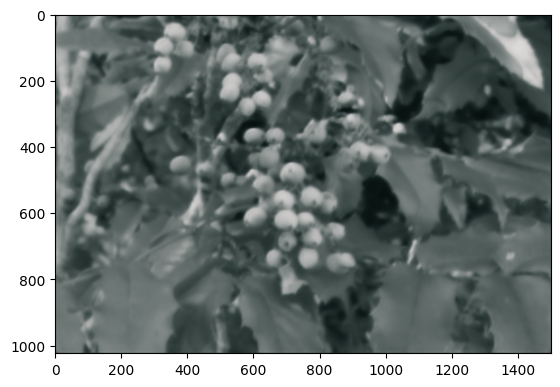

In [ ]:
y1 = (cv.resize(y.reshape((1024, 1024, 3)), (1500, 1024))*255).astype(np.uint8)
plt.imshow(y1)
y1.shape
#image output from the model

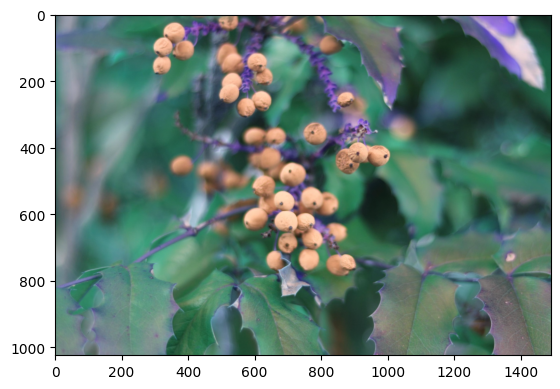

In [ ]:
t1 = cv.imread(train_bokeh + '/' + str(1) + '.jpg')
plt.imshow(t1)
#target image

In [ ]:
np.mean((cv.resize(t1, (1500, 1024)) - y1)**2)

92.74934483506945

The results of model are not satisfactory on train images itself. Let us increase the training set and see how the model performs

##### Training iteration - 2
Dataset - 1000 images

In [ ]:
#saving the model trained with 500 images 
model_saved_500 = tf.keras.models.load_model(save_dir + '/' + 'model_500', custom_objects = {'loss_function' : loss_function})

In [ ]:
image_size = (1024, 1024, 3)
batch_size = 1
training_set_size = 500
epochs = 5
start = 500
trainModel(model_saved_500, image_size, batch_size, training_set_size, epochs, start)
model_saved_500.save(save_dir + '/' + 'model_1000')

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 420ms/step - loss: 0.2898
Epoch 4/5
1/1 [==============================] - 0s 412ms/step - loss: 0.2774
Epoch 5/5
1/1 [==============================] - 0s 420ms/step - loss: 0.2626
--------------batch  47 --------------
Epoch 1/5
1/1 [==============================] - 1s 521ms/step - loss: 0.2085
Epoch 2/5
1/1 [==============================] - 0s 414ms/step - loss: 0.2203
Epoch 3/5
1/1 [==============================] - 0s 419ms/step - loss: 0.2226
Epoch 4/5
1/1 [==============================] - 0s 411ms/step - loss: 0.2145
Epoch 5/5
1/1 [==============================] - 0s 415ms/step - loss: 0.2034
--------------batch  48 --------------
Epoch 1/5
1/1 [==============================] - 1s 532ms/step - loss: 0.3589
Epoch 2/5
1/1 [==============================] - 0s 435ms/step - loss: 0.3643
Epoch 3/5
1/1 [==============================] - 0s 421ms/step - loss: 0.3578
Epoch 4/5
1/1 [========

In [ ]:
x_train1 = []
x_train1.append(cv.resize(cv.imread(train_org + '/' + str(666) + '.jpg'), (512, 512))/255)
y02 = model_saved_500(tf.convert_to_tensor(x_train1)).numpy()

(1024, 1500, 3)

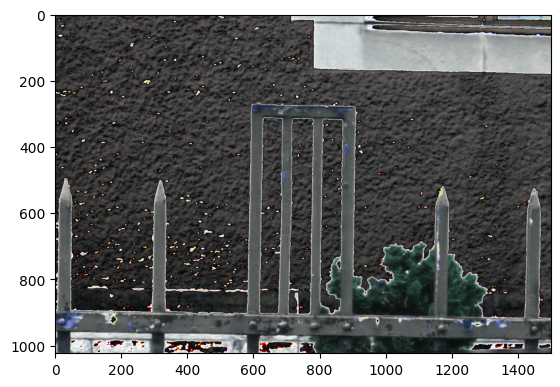

In [ ]:
y2 = (cv.resize(y02.reshape((1024, 1024, 3)), (1500, 1024))*255).astype(np.uint8)
x2 = cv.resize(cv.imread(train_org + '/' + str(666) + '.jpg'), (1500, 1024))
plt.imshow(x2 + y2)
y2.shape
#output image from model added with the input image

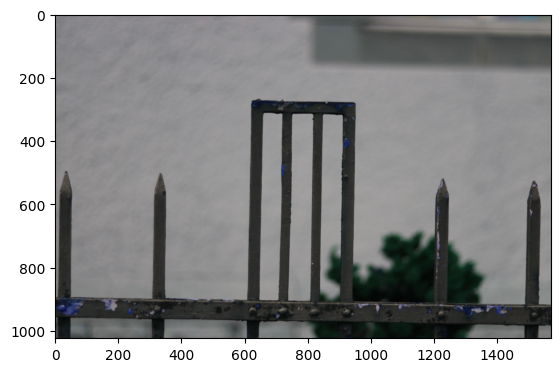

In [ ]:
t = cv.imread(train_bokeh + '/' + str(666) + '.jpg')
#np.mean((cv.resize(t, (1500, 1024)) - y2)**2)
plt.imshow(t)
#target image

The outputs of the model are still not satisfactory. Let us further increase the training set size

##### Training iteration - 3
dataset - 1500 images

In [ ]:
model_saved_1000 = tf.keras.models.load_model(save_dir + '/' + 'model_1000', custom_objects = {'loss_function' : loss_function})

In [ ]:
image_size = (1024, 1024, 3)
batch_size = 1
training_set_size = 500
epochs = 5
start = 1000
trainModel(model_saved_1000, image_size, batch_size, training_set_size, epochs, start)
model_saved_1000.save(save_dir + '/' + 'model_1500')

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 437ms/step - loss: 0.3317
Epoch 4/5
1/1 [==============================] - 0s 439ms/step - loss: 0.3249
Epoch 5/5
1/1 [==============================] - 0s 437ms/step - loss: 0.3209
--------------batch  47 --------------
Epoch 1/5
1/1 [==============================] - 1s 562ms/step - loss: 0.3977
Epoch 2/5
1/1 [==============================] - 0s 440ms/step - loss: 0.4004
Epoch 3/5
1/1 [==============================] - 0s 437ms/step - loss: 0.4006
Epoch 4/5
1/1 [==============================] - 0s 437ms/step - loss: 0.3984
Epoch 5/5
1/1 [==============================] - 0s 437ms/step - loss: 0.3942
--------------batch  48 --------------
Epoch 1/5
1/1 [==============================] - 1s 574ms/step - loss: 0.2375
Epoch 2/5
1/1 [==============================] - 0s 449ms/step - loss: 0.2320
Epoch 3/5
1/1 [==============================] - 0s 456ms/step - loss: 0.2298
Epoch 4/5
1/1 [========

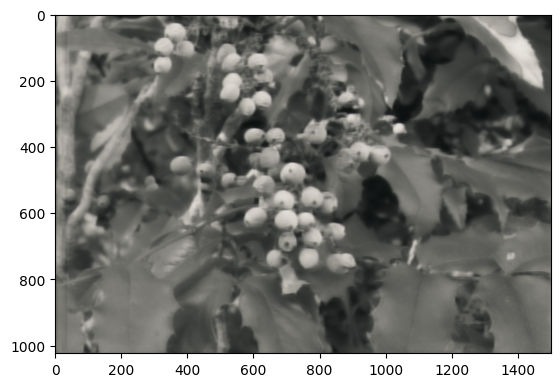

In [ ]:
y_1500 = model_saved_1000(tf.convert_to_tensor(x_train0)).numpy()
y_1500 = (cv.resize(y_1500.reshape((1024, 1024, 3)), (1500, 1024))*255).astype(np.uint8)
plt.imshow(y_1500)
#output image from the model trained with 1500 images

Although the results of the this model is better than the those of previous models, it is still far from the expected output from a training set image. The output images seem to have mostly lost information about color\
Till now the models have been trained as a whole with only the final output from level 1 optimized. The paper recommends sequential traning of the seven layers and while training a level all the levels below it are taken as pre-trained model.

##### Sequential Training of the model with tf.session

In [ ]:
def PyNet_seq(input_shape, instance_norm = True, instance_norm_level3 = False):

    with tf.compat.v1.variable_scope('generator'):

        space2depth_l0 = tf.nn.space_to_depth(input, 2)

        conv_l3_i1 = conv_multiple(space2depth_l0, 3, num_filters = 32, instance_norm = False)
        pool3 = maxpool(conv_l3_i1, 2)
        conv_l4_i1 = conv_multiple(pool3, 3, num_filters = 64, instance_norm = instance_norm)
        pool4 = maxpool(conv_l4_i1, 2)
        conv_l5_i1 = conv_multiple(pool4, 3, num_filters = 128, instance_norm = instance_norm)
        pool5 = maxpool(conv_l5_i1, 2)
        conv_l6_i1 = conv_multiple(pool5, 3, num_filters = 256, instance_norm = instance_norm)
        pool6 = maxpool(conv_l6_i1, 2)

        conv_l7_i1 = conv_multiple(pool6, 3, num_filters = 512, instance_norm = instance_norm)
        conv_l7_i2 = conv_multiple(conv_l7_i1, 3, num_filters = 512, instance_norm = instance_norm) + conv_l7_i1
        conv_l7_i3 = conv_multiple(conv_l7_i2, 3, num_filters = 512, instance_norm = instance_norm) + conv_l7_i2
        conv_l7_i4 = conv_multiple(conv_l7_i3, 3, num_filters = 512, instance_norm = instance_norm)

        conv_t6a = conv_transpose(conv_l7_i4, 256, 3, 2)      
        conv_t6b = conv_transpose(conv_l7_i4, 256, 3, 2)   

        conv_l7_out = conv_layer(conv_l7_i4, 3, 3, 1, relu=False, instance_norm=False)
        output_l7 = tf.nn.tanh(conv_l7_out) * 0.58 + 0.5

        #---------------------------------------------------------------------------------------------------------------------

        #conv_l6_i2 = tf.concat([conv_l6_i1, conv_t6a], 3)
        conv_l6_i2 = Concatenate()([conv_l6_i1, conv_t6a])
        conv_l6_i3 = conv_multiple(conv_l6_i2, 3, num_filters=256, instance_norm=instance_norm)
        conv_l6_i4 = conv_multiple(conv_l6_i3, 3, num_filters=256, instance_norm=instance_norm) + conv_l6_i3
        conv_l6_i5 = conv_multiple(conv_l6_i4, 3, num_filters=256, instance_norm=instance_norm) + conv_l6_i4
        #conv_l6_i6 = tf.concat([(conv_multiple(conv_l6_i5, 3, num_filters=256, instance_norm=instance_norm), conv_t6b)], 3)
        conv_l6_i6 = Concatenate()([conv_multiple(conv_l6_i5, 3, num_filters=256, instance_norm=instance_norm), conv_t6b])

        conv_l6_i7 = conv_multiple(conv_l6_i6, 3, num_filters=256, instance_norm=instance_norm)

        conv_t5a = conv_transpose(conv_l6_i7, 128, 3, 2)      
        conv_t5b = conv_transpose(conv_l6_i7, 128, 3, 2)      

        conv_l6_out = conv_layer(conv_l6_i7, 3, 3, 1, relu=False, instance_norm=False)
        output_l6 = tf.nn.tanh(conv_l6_out) * 0.58 + 0.5

        # -----------------------------------------------------------------------------------------------------------------------

        #conv_l5_i2 = tf.concat([conv_l5_i1, conv_t5a], 3)
        conv_l5_i2 = Concatenate()([conv_l5_i1, conv_t5a])
        conv_l5_i3 = conv_multiple(conv_l5_i2, 5, num_filters = 128, instance_norm = instance_norm) + conv_l5_i2
        conv_l5_i4 = conv_multiple(conv_l5_i3, 5, num_filters = 128, instance_norm = instance_norm) + conv_l5_i3
        conv_l5_i5 = conv_multiple(conv_l5_i4, 5, num_filters = 128, instance_norm = instance_norm) + conv_l5_i4
        #conv_l5_i6 = tf.concat([conv_multiple(conv_l5_i5, 5, num_filters = 128, instance_norm = instance_norm), conv_l5_i1], 3)
        conv_l5_i6 = Concatenate()([conv_multiple(conv_l5_i5, 5, num_filters = 128, instance_norm = instance_norm), conv_l5_i1])
        #conv_l5_i7 = tf.concat([conv_l5_i6, conv_t5b], 3)
        conv_l5_i7 = Concatenate()([conv_l5_i6, conv_t5b])

        conv_l5_i8 = conv_multiple(conv_l5_i7, 3, num_filters = 128, instance_norm = instance_norm)

        conv_t4a = conv_transpose(conv_l5_i8, 64, 3, 2)
        conv_t4b = conv_transpose(conv_l5_i8, 64, 3, 2)

        conv_l5_out = conv_layer(conv_l5_i8, 3, 3, 1, relu = False, instance_norm = False)
        output_l5 = tf.nn.tanh(conv_l5_out) * 0.58 + 0.5

        # ----------------------------------------------------------------------------------------------------------------------------------

        #conv_l4_i2 = tf.concat([conv_l4_i1, conv_t4a], 3)
        conv_l4_i2 = Concatenate()([conv_l4_i1, conv_t4a])
        #conv_l4_i3 = tf.concat([conv_multiple(conv_l4_i2, 5, num_filters = 64, instance_norm = instance_norm), conv_l4_i1], 3)
        conv_l4_i3 = Concatenate()([conv_multiple(conv_l4_i2, 5, num_filters = 64, instance_norm = instance_norm), conv_l4_i1])

        conv_l4_i4 = conv_multiple(conv_l4_i3, 7, num_filters = 64, instance_norm = instance_norm) + conv_l4_i3
        conv_l4_i5 = conv_multiple(conv_l4_i4, 7, num_filters = 64, instance_norm = instance_norm) + conv_l4_i4
        conv_l4_i6 = conv_multiple(conv_l4_i5, 7, num_filters = 64, instance_norm = instance_norm) + conv_l4_i5
        #conv_l4_i7 = tf.concat([conv_multiple(conv_l4_i6, 7, num_filters = 64, instance_norm = instance_norm), conv_l4_i1], 3)
        conv_l4_i7 = Concatenate()([conv_multiple(conv_l4_i6, 7, num_filters = 64, instance_norm = instance_norm), conv_l4_i1])

        #conv_l4_i8 = tf.concat([conv_multiple(conv_l4_i7, 5, num_filters = 64, instance_norm = instance_norm), conv_t4b], 3)
        conv_l4_i8 = Concatenate()([conv_multiple(conv_l4_i7, 5, num_filters = 64, instance_norm = instance_norm), conv_t4b])
        conv_l4_i9 = conv_multiple(conv_l4_i8, 3, num_filters = 64, instance_norm = instance_norm)

        conv_t3a = conv_transpose(conv_l4_i9, 32, 3, 2)
        conv_t3b = conv_transpose(conv_l4_i9, 32, 3, 2)

        conv_l4_out = conv_layer(conv_l4_i9, 3, 3, 1, relu = False, instance_norm = False)
        output_l4 = tf.nn.tanh(conv_l4_out) * 0.58 + 0.5    

        # ---------------------------------------------------------------------------------------------------------------------

        #conv_l3_i2 = tf.concat([conv_l3_i1, conv_t3a], 3)
        conv_l3_i2 = Concatenate()([conv_l3_i1, conv_t3a])
        #conv_l3_i3 = tf.concat([conv_multiple(conv_l3_i2, 5, num_filters = 32, instance_norm = False), conv_l3_i1], 3)
        conv_l3_i3 = Concatenate()([conv_multiple(conv_l3_i2, 5, num_filters = 32, instance_norm = False), conv_l3_i1])

        conv_l3_i4 = conv_multiple(conv_l3_i3, 7, num_filters = 32, instance_norm = False)
        conv_l3_i5 = conv_multiple(conv_l3_i4, 9, num_filters = 32, instance_norm = instance_norm_level3)
        conv_l3_i6 = conv_multiple(conv_l3_i5, 9, num_filters = 32, instance_norm = instance_norm_level3) + conv_l3_i5
        conv_l3_i7 = conv_multiple(conv_l3_i6, 9, num_filters = 32, instance_norm = instance_norm_level3) + conv_l3_i6
        conv_l3_i8 = conv_multiple(conv_l3_i7, 9, num_filters = 32, instance_norm = instance_norm_level3) + conv_l3_i7

        #conv_l3_i9 = tf.concat([conv_multiple(conv_l3_i8, 7, num_filters = 32, instance_norm = False), conv_l3_i1], 3)
        conv_l3_i9 = Concatenate()([conv_multiple(conv_l3_i8, 7, num_filters = 32, instance_norm = False), conv_l3_i1])
        #conv_l3_i10 = tf.concat([conv_multiple(conv_l3_i9, 5, num_filters = 32, instance_norm = False), conv_t3b], 3)
        conv_l3_i10 = Concatenate()([conv_multiple(conv_l3_i9, 5, num_filters = 32, instance_norm = False), conv_t3b])
        #conv_l3_i11 = tf.concat([conv_l3_i10, conv_l3_i1], 3)
        conv_l3_i11 = Concatenate()([conv_l3_i10, conv_l3_i1])
        conv_l3_i12 = conv_multiple(conv_l3_i11, 3, num_filters = 32, instance_norm = False)

        conv_l3_out = conv_layer(conv_l3_i12, 3, 3, 1, relu = False, instance_norm = False)
        output_l3 = tf.nn.tanh(conv_l3_out) * 0.58 + 0.5 

        # --------------------------------------------------------------------------------------------------------------

        conv_l2 = conv_transpose(conv_l3_i12, 8, 3, 2)
        conv_l2_out = conv_layer(conv_l2, 3, 3, 1, relu = False, instance_norm = False)
        output_l2 = tf.nn.tanh(conv_l2_out) * 0.58 + 0.5

        conv_l1 = conv_transpose(conv_l2_out, 3, 3, 2)
        conv_l1_out = conv_layer(conv_l1, 3, 3, 1, relu = False, instance_norm = False)

        output_l1 = tf.nn.tanh(conv_l1_out) * 0.58 + 0.5
        # outputs = [output_l1, output_l2, output_l3, output_l4, output_l5, output_l6, output_l7]
        # model = Model(input, output_l1)
        #return output_l1, output_l2, output_l3, output_l4, output_l5, output_l6, output_l7
        # return model
    return output_l1, output_l2, output_l3, output_l4, output_l5, output_l6, output_l7

In [ ]:
batch_size = 1
train_size = 50
learning_rate = 1e-4
num_epochs = 5
start = 0

In [ ]:
tf.compat.v1.disable_v2_behavior()

LEVELS = [7, 6, 5, 4, 3]
np.random.seed(0)

with tf.Graph().as_default(), tf.compat.v1.Session() as sess: #initializing a tensorflow session
    for LEVEL in LEVELS:

        scale = 2**(LEVEL - 2)

        input_size = 1024
        width = int(input_size/scale)
        height = int(input_size/scale)
        depth = 3

        input = tf.compat.v1.placeholder(tf.float32, [batch_size, input_size, input_size, depth])       #placeholder is an alias for a varible that will be initialized later
        target = tf.compat.v1.placeholder(tf.float32, [batch_size, height, width, depth])  #placeholders enable building graph without explicitly specifing the variables

        output_l1, output_l2, output_l3, output_l4, output_l5, output_l6, output_l7 = PyNet_seq(input)

        if LEVEL==7:
            bokeh_img = output_l7
        elif LEVEL==6:
            bokeh_img = output_l6
        elif LEVEL==5:
            bokeh_img = output_l5
        elif LEVEL==4:
            bokeh_img = output_l4
        elif LEVEL==3:
            bokeh_img = output_l3
        elif LEVEL==2:
            bokeh_img = output_l2
        elif LEVEL==1:
            bokeh_img = output_l1

        loss_ssim = tf.reduce_mean(tf.image.ssim(bokeh_img, target, max_val = 1.0))
        loss_l1 = tf.compat.v1.losses.absolute_difference(bokeh_img, target)

        if LEVEL > 1:
            loss_function_seq = loss_l1
        else:
            loss_function_seq = loss_l1 + (1 - loss_ssim)
        generator_vars = [v for v in tf.compat.v1.global_variables() if v.name.startswith('generator')]
        train_step_gen = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(loss_function_seq)

        sess.run(tf.compat.v1.global_variables_initializer())
        saver = tf.compat.v1.train.Saver(var_list = generator_vars, max_to_keep = 100)


        if LEVEL < 7:
            print("Restoring Variables")
            saver.restore(sess, "/content/drive/MyDrive/Bokeh-dataset/Bokeh-dataset/models/pynet_level_" + str(LEVEL + 1) + ".ckpt")
        saver = tf.compat.v1.train.Saver(var_list = generator_vars, max_to_keep = 100)

        training_loss = 0.0
        print('Trainging level ' + str(LEVEL))
        for i in range(train_size//batch_size):
            print('batch ', i+1)
            x_train = []
            y_train = []
            for j in range(batch_size):
                x_train.append(cv.resize(cv.imread(train_org + '/' + str(start + i*batch_size + j) + '.jpg'), (input_size, input_size)))
                y_train.append(cv.resize(cv.imread(train_bokeh + '/' + str(start + i*batch_size + j) + '.jpg'), (width, height)))

            [loss_temp, temp] = sess.run([loss_function_seq, train_step_gen], feed_dict = {input: x_train, target: y_train})
            training_loss += loss_temp
            print(loss_temp)
        saver.save(sess, '/content/drive/MyDrive/Bokeh-dataset/Bokeh-dataset/models/pynet_level_' + str(LEVEL) + '.ckpt', write_meta_graph = False)




Trainging level 7
batch  1
102.32119
batch  2
101.15229
batch  3
116.66968
batch  4
64.678185
batch  5
51.845135
batch  6
52.57462
batch  7
60.94897
batch  8
63.33536
batch  9
64.18139
batch  10
61.82397
batch  11
135.295
batch  12
82.56095
batch  13
111.48087
batch  14
154.65276
batch  15
72.54955
batch  16
49.19629
batch  17
96.0704
batch  18
122.90601
batch  19
102.38322
batch  20
101.801186
batch  21
104.03947
batch  22
106.53751
batch  23
95.716225
batch  24
104.809975
batch  25
107.09741
batch  26
75.085045
batch  27
106.547935
batch  28
98.6661
batch  29
125.518
batch  30
74.27937
batch  31
135.34123
batch  32
89.63615
batch  33
76.12417
batch  34
94.70972
batch  35
116.70158
batch  36
102.94767
batch  37
85.31779
batch  38
72.36238
batch  39
65.562904
batch  40
80.07397
batch  41
43.923397
batch  42
71.35652
batch  43
104.91675
batch  44
92.96102
batch  45
88.98055
batch  46
128.32951
batch  47
84.511475
batch  48
112.26864
batch  49
131.18044
batch  50
164.66316
Restoring Vari

NotFoundError: ignored

Sequential training using tf.compat.session could not be completed because of compatability issues of the depricated session api of temsorflow v1\
Let us implement the same sequential training using keras api

##### Sequential Training using Keras API

In [ ]:
def PyNet_seq2(input_shape, instance_norm = True, instance_norm_level3 = False):
    input = Input(input_shape)
    #with tf.compat.v1.variable_scope("generator"):

    space2depth_l0 = tf.nn.space_to_depth(input, 2)

    conv_l3_i1 = conv_multiple(space2depth_l0, 3, num_filters = 32, instance_norm = False)
    pool3 = maxpool(conv_l3_i1, 2)
    conv_l4_i1 = conv_multiple(pool3, 3, num_filters = 64, instance_norm = instance_norm)
    pool4 = maxpool(conv_l4_i1, 2)
    conv_l5_i1 = conv_multiple(pool4, 3, num_filters = 128, instance_norm = instance_norm)
    pool5 = maxpool(conv_l5_i1, 2)
    conv_l6_i1 = conv_multiple(pool5, 3, num_filters = 256, instance_norm = instance_norm)
    pool6 = maxpool(conv_l6_i1, 2)

    conv_l7_i1 = conv_multiple(pool6, 3, num_filters = 512, instance_norm = instance_norm)
    conv_l7_i2 = conv_multiple(conv_l7_i1, 3, num_filters = 512, instance_norm = instance_norm) + conv_l7_i1
    conv_l7_i3 = conv_multiple(conv_l7_i2, 3, num_filters = 512, instance_norm = instance_norm) + conv_l7_i2
    conv_l7_i4 = conv_multiple(conv_l7_i3, 3, num_filters = 512, instance_norm = instance_norm)

    conv_t6a = conv_transpose(conv_l7_i4, 256, 3, 2)      
    conv_t6b = conv_transpose(conv_l7_i4, 256, 3, 2)   

    conv_l7_out = conv_layer(conv_l7_i4, 3, 3, 1, relu=False, instance_norm=False)
    output_l7 = tf.nn.tanh(conv_l7_out) * 0.58 + 0.5

    #---------------------------------------------------------------------------------------------------------------------

    #conv_l6_i2 = tf.concat([conv_l6_i1, conv_t6a], 3)
    conv_l6_i2 = Concatenate()([conv_l6_i1, conv_t6a])
    conv_l6_i3 = conv_multiple(conv_l6_i2, 3, num_filters=256, instance_norm=instance_norm)
    conv_l6_i4 = conv_multiple(conv_l6_i3, 3, num_filters=256, instance_norm=instance_norm) + conv_l6_i3
    conv_l6_i5 = conv_multiple(conv_l6_i4, 3, num_filters=256, instance_norm=instance_norm) + conv_l6_i4
    #conv_l6_i6 = tf.concat([(conv_multiple(conv_l6_i5, 3, num_filters=256, instance_norm=instance_norm), conv_t6b)], 3)
    conv_l6_i6 = Concatenate()([conv_multiple(conv_l6_i5, 3, num_filters=256, instance_norm=instance_norm), conv_t6b])

    conv_l6_i7 = conv_multiple(conv_l6_i6, 3, num_filters=256, instance_norm=instance_norm)

    conv_t5a = conv_transpose(conv_l6_i7, 128, 3, 2)      
    conv_t5b = conv_transpose(conv_l6_i7, 128, 3, 2)      

    conv_l6_out = conv_layer(conv_l6_i7, 3, 3, 1, relu=False, instance_norm=False)
    output_l6 = tf.nn.tanh(conv_l6_out) * 0.58 + 0.5

    # -----------------------------------------------------------------------------------------------------------------------

    #conv_l5_i2 = tf.concat([conv_l5_i1, conv_t5a], 3)
    conv_l5_i2 = Concatenate()([conv_l5_i1, conv_t5a])
    conv_l5_i3 = conv_multiple(conv_l5_i2, 5, num_filters = 128, instance_norm = instance_norm) + conv_l5_i2
    conv_l5_i4 = conv_multiple(conv_l5_i3, 5, num_filters = 128, instance_norm = instance_norm) + conv_l5_i3
    conv_l5_i5 = conv_multiple(conv_l5_i4, 5, num_filters = 128, instance_norm = instance_norm) + conv_l5_i4
    #conv_l5_i6 = tf.concat([conv_multiple(conv_l5_i5, 5, num_filters = 128, instance_norm = instance_norm), conv_l5_i1], 3)
    conv_l5_i6 = Concatenate()([conv_multiple(conv_l5_i5, 5, num_filters = 128, instance_norm = instance_norm), conv_l5_i1])
    #conv_l5_i7 = tf.concat([conv_l5_i6, conv_t5b], 3)
    conv_l5_i7 = Concatenate()([conv_l5_i6, conv_t5b])

    conv_l5_i8 = conv_multiple(conv_l5_i7, 3, num_filters = 128, instance_norm = instance_norm)

    conv_t4a = conv_transpose(conv_l5_i8, 64, 3, 2)
    conv_t4b = conv_transpose(conv_l5_i8, 64, 3, 2)

    conv_l5_out = conv_layer(conv_l5_i8, 3, 3, 1, relu = False, instance_norm = False)
    output_l5 = tf.nn.tanh(conv_l5_out) * 0.58 + 0.5

    # ----------------------------------------------------------------------------------------------------------------------------------

    #conv_l4_i2 = tf.concat([conv_l4_i1, conv_t4a], 3)
    conv_l4_i2 = Concatenate()([conv_l4_i1, conv_t4a])
    #conv_l4_i3 = tf.concat([conv_multiple(conv_l4_i2, 5, num_filters = 64, instance_norm = instance_norm), conv_l4_i1], 3)
    conv_l4_i3 = Concatenate()([conv_multiple(conv_l4_i2, 5, num_filters = 64, instance_norm = instance_norm), conv_l4_i1])

    conv_l4_i4 = conv_multiple(conv_l4_i3, 7, num_filters = 64, instance_norm = instance_norm) + conv_l4_i3
    conv_l4_i5 = conv_multiple(conv_l4_i4, 7, num_filters = 64, instance_norm = instance_norm) + conv_l4_i4
    conv_l4_i6 = conv_multiple(conv_l4_i5, 7, num_filters = 64, instance_norm = instance_norm) + conv_l4_i5
    #conv_l4_i7 = tf.concat([conv_multiple(conv_l4_i6, 7, num_filters = 64, instance_norm = instance_norm), conv_l4_i1], 3)
    conv_l4_i7 = Concatenate()([conv_multiple(conv_l4_i6, 7, num_filters = 64, instance_norm = instance_norm), conv_l4_i1])

    #conv_l4_i8 = tf.concat([conv_multiple(conv_l4_i7, 5, num_filters = 64, instance_norm = instance_norm), conv_t4b], 3)
    conv_l4_i8 = Concatenate()([conv_multiple(conv_l4_i7, 5, num_filters = 64, instance_norm = instance_norm), conv_t4b])
    conv_l4_i9 = conv_multiple(conv_l4_i8, 3, num_filters = 64, instance_norm = instance_norm)

    conv_t3a = conv_transpose(conv_l4_i9, 32, 3, 2)
    conv_t3b = conv_transpose(conv_l4_i9, 32, 3, 2)

    conv_l4_out = conv_layer(conv_l4_i9, 3, 3, 1, relu = False, instance_norm = False)
    output_l4 = tf.nn.tanh(conv_l4_out) * 0.58 + 0.5    

    # ---------------------------------------------------------------------------------------------------------------------

    #conv_l3_i2 = tf.concat([conv_l3_i1, conv_t3a], 3)
    conv_l3_i2 = Concatenate()([conv_l3_i1, conv_t3a])
    #conv_l3_i3 = tf.concat([conv_multiple(conv_l3_i2, 5, num_filters = 32, instance_norm = False), conv_l3_i1], 3)
    conv_l3_i3 = Concatenate()([conv_multiple(conv_l3_i2, 5, num_filters = 32, instance_norm = False), conv_l3_i1])

    conv_l3_i4 = conv_multiple(conv_l3_i3, 7, num_filters = 32, instance_norm = False)
    conv_l3_i5 = conv_multiple(conv_l3_i4, 9, num_filters = 32, instance_norm = instance_norm_level3)
    conv_l3_i6 = conv_multiple(conv_l3_i5, 9, num_filters = 32, instance_norm = instance_norm_level3) + conv_l3_i5
    conv_l3_i7 = conv_multiple(conv_l3_i6, 9, num_filters = 32, instance_norm = instance_norm_level3) + conv_l3_i6
    conv_l3_i8 = conv_multiple(conv_l3_i7, 9, num_filters = 32, instance_norm = instance_norm_level3) + conv_l3_i7

    #conv_l3_i9 = tf.concat([conv_multiple(conv_l3_i8, 7, num_filters = 32, instance_norm = False), conv_l3_i1], 3)
    conv_l3_i9 = Concatenate()([conv_multiple(conv_l3_i8, 7, num_filters = 32, instance_norm = False), conv_l3_i1])
    #conv_l3_i10 = tf.concat([conv_multiple(conv_l3_i9, 5, num_filters = 32, instance_norm = False), conv_t3b], 3)
    conv_l3_i10 = Concatenate()([conv_multiple(conv_l3_i9, 5, num_filters = 32, instance_norm = False), conv_t3b])
    #conv_l3_i11 = tf.concat([conv_l3_i10, conv_l3_i1], 3)
    conv_l3_i11 = Concatenate()([conv_l3_i10, conv_l3_i1])
    conv_l3_i12 = conv_multiple(conv_l3_i11, 3, num_filters = 32, instance_norm = False)

    conv_l3_out = conv_layer(conv_l3_i12, 3, 3, 1, relu = False, instance_norm = False)
    output_l3 = tf.nn.tanh(conv_l3_out) * 0.58 + 0.5 

    # --------------------------------------------------------------------------------------------------------------

    conv_l2 = conv_transpose(conv_l3_i12, 8, 3, 2)
    conv_l2_out = conv_layer(conv_l2, 3, 3, 1, relu = False, instance_norm = False)
    output_l2 = tf.nn.tanh(conv_l2_out) * 0.58 + 0.5

    conv_l1 = conv_transpose(conv_l2_out, 3, 3, 2)
    conv_l1_out = conv_layer(conv_l1, 3, 3, 1, relu = False, instance_norm = False)

    output_l1 = tf.nn.tanh(conv_l1_out) * 0.58 + 0.5
    outputs = [output_l1, output_l2, output_l3, output_l4, output_l5, output_l6, output_l7]
    model = [model7, model6, model5, model4, model3, model2, model1] = [Model(input, output_l7), Model(input, output_l6), Model(input, output_l5), Model(input, output_l4), Model(input, output_l3), Model(input, output_l2), Model(input, output_l1)]
    #return output_l1, output_l2, output_l3, output_l4, output_l5, output_l6, output_l7
    return model

In [ ]:
loss1 = tf.keras.losses.MeanAbsoluteError()
def loss2(out_img, target):
    return tf.math.reduce_mean(tf.math.abs(out_img - target), axis = -1) + tf.math.reduce_mean(tf.image.ssim(bokeh_img, target, max_val = 1.0))

In [ ]:
import cv2 as cv
def trainModel_seq(modelA, image_size, batch_size, train_set_size, epochs, start, LEVEL):
    l,b,h = image_size

    for i in range(train_set_size//batch_size):
    print('--------------batch ', i+1, '--------------')
    x_train = []
    y_train = []
    for j in range(batch_size):
        x_train.append(cv.resize(cv.imread(train_org + '/' + str(start + i*batch_size + j) + '.jpg'), (b//2, l//2))/255)
        y_train.append(cv.resize(cv.imread(train_bokeh + '/' + str(start + i*batch_size + j) + '.jpg'), (int(b/(2**(LEVEL-1))), int(b/(2**(LEVEL-1))) ))/255)
    modelA.fit(tf.convert_to_tensor(x_train), tf.convert_to_tensor(y_train), epochs = epochs)

In [ ]:
image_size = (1024, 1024, 3)
batch_size = 1
train_set_size = 100
start = 0
epochs = 10
[model7, model6, model5, model4, model3, model2, model1] = PyNet_seq2((512, 512, 3))

In [ ]:
#Training the model with a dataset of 100 images
LEVEL = 7
model7.compile('adam', loss = loss_function)
trainModel_seq(model7, image_size, batch_size, train_set_size, epochs, start, LEVEL)
level7_weights = model7.get_weights()

model7.save(save_dir + '/model7')

--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 1.1778
Epoch 2/10
1/1 [==============================] - 0s 52ms/step - loss: 1.0978
Epoch 3/10
1/1 [==============================] - 0s 55ms/step - loss: 1.4904
Epoch 4/10
1/1 [==============================] - 0s 49ms/step - loss: 1.5157
Epoch 5/10
1/1 [==============================] - 0s 50ms/step - loss: 1.5022
Epoch 6/10
1/1 [==============================] - 0s 45ms/step - loss: 1.5067
Epoch 7/10
1/1 [==============================] - 0s 42ms/step - loss: 1.3672
Epoch 8/10
1/1 [==============================] - 0s 43ms/step - loss: 1.1844
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 1.1774
Epoch 10/10
1/1 [==============================] - 0s 40ms/step - loss: 1.1527
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 0s 42ms/step - loss: 1.1465
Epoch 2/10
1/1 [==============================] - 0s 37ms/step - lo

In [ ]:
LEVEL = 6
model6.weights[0:len(level7_weights)] = level7_weights
model6.compile('adam', loss = loss_function)
trainModel_seq(model6, image_size, batch_size, train_set_size, epochs, start, LEVEL)
level6_weights = model6.get_weights()

model6.save(save_dir + '/model6')

--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 12s 12s/step - loss: 1.0754
Epoch 2/10
1/1 [==============================] - 0s 69ms/step - loss: 1.1159
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.9935
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.8244
Epoch 5/10
1/1 [==============================] - 0s 54ms/step - loss: 0.6564
Epoch 6/10
1/1 [==============================] - 0s 52ms/step - loss: 0.6905
Epoch 7/10
1/1 [==============================] - 0s 53ms/step - loss: 0.5461
Epoch 8/10
1/1 [==============================] - 0s 49ms/step - loss: 0.8181
Epoch 9/10
1/1 [==============================] - 0s 48ms/step - loss: 0.5655
Epoch 10/10
1/1 [==============================] - 0s 47ms/step - loss: 0.5692
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 0s 52ms/step - loss: 0.8923
Epoch 2/10
1/1 [==============================] - 0s 49ms/step - 

In [ ]:
LEVEL = 5
model5.weights[0:len(level6_weights)] = level6_weights
model5.compile('adam', loss = loss_function)
trainModel_seq(model5, image_size, batch_size, train_set_size, epochs, start, LEVEL)
level5_weights = model5.get_weights()

model5.save(save_dir + '/model5')

--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 19s 19s/step - loss: 0.9897
Epoch 2/10
1/1 [==============================] - 0s 134ms/step - loss: 0.9424
Epoch 3/10
1/1 [==============================] - 0s 105ms/step - loss: 0.8276
Epoch 4/10
1/1 [==============================] - 0s 92ms/step - loss: 0.8220
Epoch 5/10
1/1 [==============================] - 0s 86ms/step - loss: 0.6911
Epoch 6/10
1/1 [==============================] - 0s 83ms/step - loss: 0.5789
Epoch 7/10
1/1 [==============================] - 0s 83ms/step - loss: 0.4839
Epoch 8/10
1/1 [==============================] - 0s 84ms/step - loss: 0.3896
Epoch 9/10
1/1 [==============================] - 0s 84ms/step - loss: 0.7392
Epoch 10/10
1/1 [==============================] - 0s 82ms/step - loss: 0.3564
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 0s 84ms/step - loss: 0.7247
Epoch 2/10
1/1 [==============================] - 0s 83ms/step 

In [ ]:
LEVEL = 4
model4.weights[0:len(level5_weights)] = level5_weights
model4.compile('adam', loss = loss_function)
trainModel_seq(model4, image_size, batch_size, train_set_size, epochs, start, LEVEL)
level4_weights = model4.get_weights()

model4.save(save_dir + '/model4')

--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 32s 32s/step - loss: 0.8870
Epoch 2/10
1/1 [==============================] - 0s 277ms/step - loss: 0.9041
Epoch 3/10
1/1 [==============================] - 0s 174ms/step - loss: 0.8291
Epoch 4/10
1/1 [==============================] - 0s 173ms/step - loss: 0.8160
Epoch 5/10
1/1 [==============================] - 0s 175ms/step - loss: 0.7798
Epoch 6/10
1/1 [==============================] - 0s 176ms/step - loss: 0.7458
Epoch 7/10
1/1 [==============================] - 0s 175ms/step - loss: 0.7566
Epoch 8/10
1/1 [==============================] - 0s 177ms/step - loss: 0.7198
Epoch 9/10
1/1 [==============================] - 0s 177ms/step - loss: 0.6828
Epoch 10/10
1/1 [==============================] - 0s 173ms/step - loss: 0.6509
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 0s 177ms/step - loss: 0.7580
Epoch 2/10
1/1 [==============================] - 0s 17

In [ ]:
LEVEL = 3
model3.weights[0:len(level4_weights)] = level4_weights
model3.compile('adam', loss = loss_function)
trainModel_seq(model3, image_size, batch_size, train_set_size, epochs, start, LEVEL)
level3_weights = model3.get_weights()

model3.save(save_dir + '/model3')

--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 54s 54s/step - loss: 0.7964
Epoch 2/10
1/1 [==============================] - 0s 486ms/step - loss: 0.8577
Epoch 3/10
1/1 [==============================] - 0s 410ms/step - loss: 0.7182
Epoch 4/10
1/1 [==============================] - 0s 417ms/step - loss: 0.6977
Epoch 5/10
1/1 [==============================] - 0s 415ms/step - loss: 0.6735
Epoch 6/10
1/1 [==============================] - 0s 414ms/step - loss: 0.6550
Epoch 7/10
1/1 [==============================] - 0s 419ms/step - loss: 0.6354
Epoch 8/10
1/1 [==============================] - 0s 423ms/step - loss: 0.6008
Epoch 9/10
1/1 [==============================] - 0s 422ms/step - loss: 0.5792
Epoch 10/10
1/1 [==============================] - 0s 423ms/step - loss: 0.5585
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 1s 501ms/step - loss: 0.6238
Epoch 2/10
1/1 [==============================] - 0s 41

In [ ]:
LEVEL = 2
model2.weights[0:len(level3_weights)] = level3_weights
model2.compile('adam', loss = loss_function)
trainModel_seq(model2, image_size, batch_size, train_set_size, epochs, start, LEVEL)
level2_weights = model2.get_weights()

model2.save(save_dir + '/model2')

--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 55s 55s/step - loss: 1.1599
Epoch 2/10
1/1 [==============================] - 1s 514ms/step - loss: 1.1036
Epoch 3/10
1/1 [==============================] - 0s 411ms/step - loss: 1.0401
Epoch 4/10
1/1 [==============================] - 0s 410ms/step - loss: 0.9749
Epoch 5/10
1/1 [==============================] - 0s 417ms/step - loss: 0.9068
Epoch 6/10
1/1 [==============================] - 0s 414ms/step - loss: 0.8412
Epoch 7/10
1/1 [==============================] - 0s 412ms/step - loss: 0.7832
Epoch 8/10
1/1 [==============================] - 0s 415ms/step - loss: 0.7367
Epoch 9/10
1/1 [==============================] - 0s 412ms/step - loss: 0.7037
Epoch 10/10
1/1 [==============================] - 0s 412ms/step - loss: 0.6795
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 1s 501ms/step - loss: 0.5556
Epoch 2/10
1/1 [==============================] - 0s 41

In [ ]:
# model2_saved = tf.keras.models.load_model(save_dir + '/' + 'model2', custom_objects = {'loss_function' : loss_function})
# level2_weights = model2_saved.weights

In [ ]:
LEVEL = 1
model1.weights[0:len(level2_weights)] = level2_weights
model1.compile('adam', loss = loss1)
trainModel_seq(model1, image_size, batch_size, train_set_size, epochs, start, LEVEL)
level1_weights = model1.get_weights()

model1.save(save_dir + '/model1')

--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 56s 56s/step - loss: 0.1786
Epoch 2/10
1/1 [==============================] - 1s 510ms/step - loss: 0.1781
Epoch 3/10
1/1 [==============================] - 0s 417ms/step - loss: 0.1713
Epoch 4/10
1/1 [==============================] - 0s 419ms/step - loss: 0.1725
Epoch 5/10
1/1 [==============================] - 0s 417ms/step - loss: 0.1652
Epoch 6/10
1/1 [==============================] - 0s 417ms/step - loss: 0.1619
Epoch 7/10
1/1 [==============================] - 0s 419ms/step - loss: 0.1590
Epoch 8/10
1/1 [==============================] - 0s 421ms/step - loss: 0.1565
Epoch 9/10
1/1 [==============================] - 0s 417ms/step - loss: 0.1540
Epoch 10/10
1/1 [==============================] - 0s 420ms/step - loss: 0.1514
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 1s 515ms/step - loss: 0.1151
Epoch 2/10
1/1 [==============================] - 0s 41

In [ ]:
x_train0 = []
x_train0.append(cv.resize(cv.imread(train_org + '/' + str(1) + '.jpg'), (512, 512))/255)
y = model1(tf.convert_to_tensor(x_train0)).numpy()

(1024, 1500, 3)

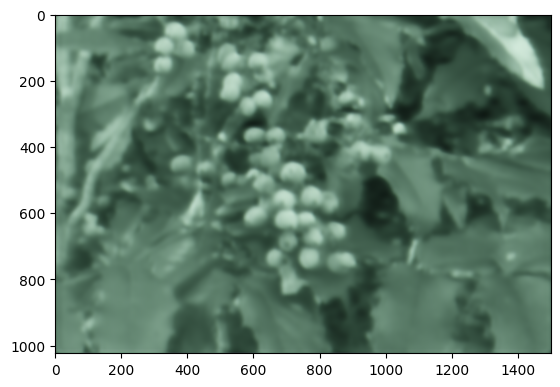

In [ ]:
y1 = (cv.resize(y.reshape((1024, 1024, 3)), (1500, 1024))*255).astype(np.uint8)
plt.imshow(y1)
y1.shape
#output image from sequqntial model trained with 100 images

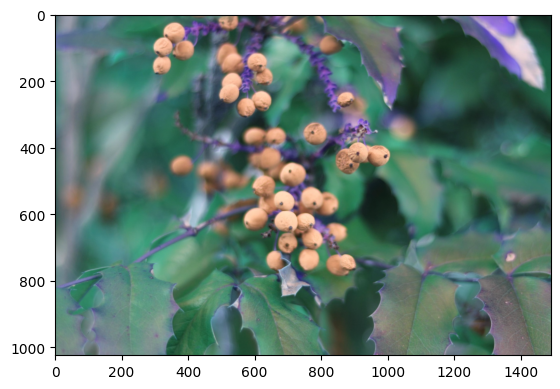

In [ ]:
t1 = cv.imread(train_bokeh + '/' + str(1) + '.jpg')
plt.imshow(t1)
#target image

In [ ]:
np.mean((cv.resize(t1, (1500, 1024)) - y1)**2)

87.34657595486111

Even now the model is performing very badly on training set itself. Let us train the model with a very small dataset and see if it will be able to fit for that or not

#### Sequential model trained with 25 images

In [ ]:
#This function impliments the sequential training for a given set of hyperparameters
def trainModelSequrntially(Model, image_size, batch_size, train_set_size, start, epochs):
    [model7, model6, model5, model4, model3, model2, model1] = Model
    #-------------------training layer 7----------------------------#
    print('##-----Training Layer 7 -----##')
    model7.compile('adam', loss = loss_function)
    trainModel_seq(model7, image_size, batch_size, train_set_size, epochs, start, 7)
    level7_weights = model7.get_weights()
    model7.save(save_dir + str(train_set_size) + ' training images ' + '/model7')

    #-------------------training layer 6----------------------------#
    print('##-----Training Layer 6 -----##')
    model6.weights[0:len(level7_weights)] = level7_weights
    model6.compile('adam', loss = loss_function)
    trainModel_seq(model6, image_size, batch_size, train_set_size, epochs, start, 6)
    level6_weights = model6.get_weights()
    model6.save(save_dir + str(train_set_size) + ' training images ' + '/model6')

    #-------------------training layer 5----------------------------#
    print('##-----Training Layer 5 -----##')
    model5.weights[0:len(level6_weights)] = level6_weights
    model5.compile('adam', loss = loss_function)
    trainModel_seq(model5, image_size, batch_size, train_set_size, epochs, start, 5)
    level5_weights = model5.get_weights()
    model5.save(save_dir + str(train_set_size) + ' training images ' + '/model5')

    #-------------------training layer 4----------------------------#
    print('##-----Training Layer 4 -----##')
    model4.weights[0:len(level5_weights)] = level5_weights
    model4.compile('adam', loss = loss_function)
    trainModel_seq(model4, image_size, batch_size, train_set_size, epochs, start, 4)
    level4_weights = model4.get_weights()
    model4.save(save_dir + str(train_set_size) + ' training images ' + '/model4')

    #-------------------training layer 3----------------------------#
    print('##-----Training Layer 3 -----##')
    model3.weights[0:len(level4_weights)] = level4_weights
    model3.compile('adam', loss = loss_function)
    trainModel_seq(model3, image_size, batch_size, train_set_size, epochs, start, 3)
    level3_weights = model3.get_weights()
    model3.save(save_dir + str(train_set_size) + ' training images ' + '/model3')

    #-------------------training layer 2----------------------------#
    print('##-----Training Layer 2 -----##')
    model2.weights[0:len(level3_weights)] = level3_weights
    model2.compile('adam', loss = loss_function)
    trainModel_seq(model2, image_size, batch_size, train_set_size, epochs, start, 2)
    level2_weights = model2.get_weights()
    model2.save(save_dir + str(train_set_size) + ' training images ' + '/model2')

    #-------------------training layer 1----------------------------#
    print('##-----Training Layer 1 -----##')
    model1.weights[0:len(level2_weights)] = level2_weights
    model1.compile('adam', loss = loss1)
    trainModel_seq(model1, image_size, batch_size, train_set_size, epochs, start, 1)
    level1_weights = model1.get_weights()
    model1.save(save_dir + str(train_set_size) + ' training images ' + '/model1')

In [ ]:
image_size = ((1024, 1024, 3))
Model_25 = PyNet_seq2((512, 512, 3))
trainModelSequrntially(Model_25, image_size, batch_size = 1, train_set_size = 25, start = 0, epochs = 10)

##-----Training Layer 7 -----##
--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 21s 21s/step - loss: 1.1778
Epoch 2/10
1/1 [==============================] - 0s 38ms/step - loss: 1.3270
Epoch 3/10
1/1 [==============================] - 0s 36ms/step - loss: 1.3410
Epoch 4/10
1/1 [==============================] - 0s 37ms/step - loss: 1.1985
Epoch 5/10
1/1 [==============================] - 0s 36ms/step - loss: 1.1238
Epoch 6/10
1/1 [==============================] - 0s 38ms/step - loss: 1.0860
Epoch 7/10
1/1 [==============================] - 0s 34ms/step - loss: 1.2968
Epoch 8/10
1/1 [==============================] - 0s 37ms/step - loss: 0.9670
Epoch 9/10
1/1 [==============================] - 0s 35ms/step - loss: 1.0139
Epoch 10/10
1/1 [==============================] - 0s 36ms/step - loss: 1.1343
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 0s 65ms/step - loss: 1.2267
Epoch 2/10
1/1 [=================

##-----Training Layer 6 -----##
--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 13s 13s/step - loss: 1.0849
Epoch 2/10
1/1 [==============================] - 0s 72ms/step - loss: 1.0308
Epoch 3/10
1/1 [==============================] - 0s 70ms/step - loss: 1.5544
Epoch 4/10
1/1 [==============================] - 0s 69ms/step - loss: 1.4719
Epoch 5/10
1/1 [==============================] - 0s 69ms/step - loss: 1.4236
Epoch 6/10
1/1 [==============================] - 0s 59ms/step - loss: 1.4737
Epoch 7/10
1/1 [==============================] - 0s 52ms/step - loss: 1.4743
Epoch 8/10
1/1 [==============================] - 0s 50ms/step - loss: 1.4743
Epoch 9/10
1/1 [==============================] - 0s 49ms/step - loss: 1.4743
Epoch 10/10
1/1 [==============================] - 0s 49ms/step - loss: 1.4743
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 0s 50ms/step - loss: 1.5406
Epoch 2/10
1/1 [=================

##-----Training Layer 5 -----##
--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 21s 21s/step - loss: 1.5310
Epoch 2/10
1/1 [==============================] - 0s 133ms/step - loss: 1.5310
Epoch 3/10
1/1 [==============================] - 0s 114ms/step - loss: 1.5310
Epoch 4/10
1/1 [==============================] - 0s 99ms/step - loss: 1.5310
Epoch 5/10
1/1 [==============================] - 0s 78ms/step - loss: 1.5310
Epoch 6/10
1/1 [==============================] - 0s 82ms/step - loss: 1.5310
Epoch 7/10
1/1 [==============================] - 0s 78ms/step - loss: 1.5310
Epoch 8/10
1/1 [==============================] - 0s 77ms/step - loss: 1.5310
Epoch 9/10
1/1 [==============================] - 0s 80ms/step - loss: 1.5310
Epoch 10/10
1/1 [==============================] - 0s 75ms/step - loss: 1.5310
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 0s 78ms/step - loss: 1.5897
Epoch 2/10
1/1 [===============

##-----Training Layer 4 -----##
--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 33s 33s/step - loss: 1.4748
Epoch 2/10
1/1 [==============================] - 0s 297ms/step - loss: 1.4748
Epoch 3/10
1/1 [==============================] - 0s 161ms/step - loss: 1.4748
Epoch 4/10
1/1 [==============================] - 0s 158ms/step - loss: 1.4748
Epoch 5/10
1/1 [==============================] - 0s 160ms/step - loss: 1.4748
Epoch 6/10
1/1 [==============================] - 0s 161ms/step - loss: 1.4748
Epoch 7/10
1/1 [==============================] - 0s 159ms/step - loss: 1.4748
Epoch 8/10
1/1 [==============================] - 0s 158ms/step - loss: 1.4748
Epoch 9/10
1/1 [==============================] - 0s 160ms/step - loss: 1.4748
Epoch 10/10
1/1 [==============================] - 0s 158ms/step - loss: 1.4748
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 0s 161ms/step - loss: 1.5284
Epoch 2/10
1/1 [=======

##-----Training Layer 3 -----##
--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 55s 55s/step - loss: 1.6138
Epoch 2/10
1/1 [==============================] - 1s 507ms/step - loss: 1.6138
Epoch 3/10
1/1 [==============================] - 0s 395ms/step - loss: 1.6138
Epoch 4/10
1/1 [==============================] - 0s 407ms/step - loss: 1.6138
Epoch 5/10
1/1 [==============================] - 0s 408ms/step - loss: 1.6138
Epoch 6/10
1/1 [==============================] - 0s 405ms/step - loss: 1.6138
Epoch 7/10
1/1 [==============================] - 0s 399ms/step - loss: 1.6138
Epoch 8/10
1/1 [==============================] - 0s 403ms/step - loss: 1.6138
Epoch 9/10
1/1 [==============================] - 0s 405ms/step - loss: 1.6138
Epoch 10/10
1/1 [==============================] - 0s 400ms/step - loss: 1.6138
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 1s 513ms/step - loss: 1.5971
Epoch 2/10
1/1 [=======

##-----Training Layer 2 -----##
--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 54s 54s/step - loss: 1.6157
Epoch 2/10
1/1 [==============================] - 1s 523ms/step - loss: 1.6157
Epoch 3/10
1/1 [==============================] - 0s 399ms/step - loss: 1.6157
Epoch 4/10
1/1 [==============================] - 0s 410ms/step - loss: 1.6157
Epoch 5/10
1/1 [==============================] - 0s 408ms/step - loss: 1.6157
Epoch 6/10
1/1 [==============================] - 0s 402ms/step - loss: 1.6157
Epoch 7/10
1/1 [==============================] - 0s 408ms/step - loss: 1.6157
Epoch 8/10
1/1 [==============================] - 0s 409ms/step - loss: 1.6157
Epoch 9/10
1/1 [==============================] - 0s 404ms/step - loss: 1.6157
Epoch 10/10
1/1 [==============================] - 0s 414ms/step - loss: 1.6157
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 0s 424ms/step - loss: 1.5951
Epoch 2/10
1/1 [=======

##-----Training Layer 1 -----##
--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 53s 53s/step - loss: 0.5374
Epoch 2/10
1/1 [==============================] - 0s 492ms/step - loss: 0.5374
Epoch 3/10
1/1 [==============================] - 0s 410ms/step - loss: 0.5374
Epoch 4/10
1/1 [==============================] - 0s 405ms/step - loss: 0.5374
Epoch 5/10
1/1 [==============================] - 0s 415ms/step - loss: 0.5374
Epoch 6/10
1/1 [==============================] - 0s 409ms/step - loss: 0.5374
Epoch 7/10
1/1 [==============================] - 0s 411ms/step - loss: 0.5374
Epoch 8/10
1/1 [==============================] - 0s 412ms/step - loss: 0.5374
Epoch 9/10
1/1 [==============================] - 0s 413ms/step - loss: 0.5374
Epoch 10/10
1/1 [==============================] - 0s 408ms/step - loss: 0.5374
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 1s 519ms/step - loss: 0.5749
Epoch 2/10
1/1 [=======

In [ ]:
x_train0 = []
x_train0.append(cv.resize(cv.imread(train_org + '/' + str(1) + '.jpg'), (512, 512))/255)
y = Model_25[6](tf.convert_to_tensor(x_train0)).numpy()

In [ ]:
y1 = (cv.resize(y.reshape((1024, 1024, 3)), (1500, 1024))*255).astype(np.uint8)
plt.imshow(y1)
y1.shape

The output obtained is a very basic grid and nearly uniform color(the image got removed when the above cell was accidently recompiled). This suggests that the dataset is very small for the sequential model to learn bokeh effect rendering. Let us increase the dataset gradually and see the performance change

#### Sequential training with a dataset of 200 Images

In [ ]:
image_size = ((1024, 1024, 3))
Model_200 = PyNet_seq2((512, 512, 3))
trainModelSequrntially(Model_200, image_size, batch_size = 1, train_set_size = 200, start = 0, epochs = 10)

##-----Training Layer 7 -----##
--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 19s 19s/step - loss: 1.1769
Epoch 2/10
1/1 [==============================] - 0s 39ms/step - loss: 1.3980
Epoch 3/10
1/1 [==============================] - 0s 37ms/step - loss: 1.2005
Epoch 4/10
1/1 [==============================] - 0s 39ms/step - loss: 1.1392
Epoch 5/10
1/1 [==============================] - 0s 37ms/step - loss: 0.9957
Epoch 6/10
1/1 [==============================] - 0s 39ms/step - loss: 0.8539
Epoch 7/10
1/1 [==============================] - 0s 39ms/step - loss: 0.9593
Epoch 8/10
1/1 [==============================] - 0s 36ms/step - loss: 0.8039
Epoch 9/10
1/1 [==============================] - 0s 35ms/step - loss: 0.8062
Epoch 10/10
1/1 [==============================] - 0s 35ms/step - loss: 0.7156
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 0s 41ms/step - loss: 0.8079
Epoch 2/10
1/1 [=================

##-----Training Layer 6 -----##
--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 12s 12s/step - loss: 1.0806
Epoch 2/10
1/1 [==============================] - 0s 75ms/step - loss: 0.9885
Epoch 3/10
1/1 [==============================] - 0s 75ms/step - loss: 0.7126
Epoch 4/10
1/1 [==============================] - 0s 65ms/step - loss: 1.2753
Epoch 5/10
1/1 [==============================] - 0s 71ms/step - loss: 1.3758
Epoch 6/10
1/1 [==============================] - 0s 64ms/step - loss: 0.6655
Epoch 7/10
1/1 [==============================] - 0s 53ms/step - loss: 0.6281
Epoch 8/10
1/1 [==============================] - 0s 59ms/step - loss: 0.5252
Epoch 9/10
1/1 [==============================] - 0s 57ms/step - loss: 0.4797
Epoch 10/10
1/1 [==============================] - 0s 55ms/step - loss: 0.4488
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.8362
Epoch 2/10
1/1 [=================

##-----Training Layer 5 -----##
--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 18s 18s/step - loss: 1.0069
Epoch 2/10
1/1 [==============================] - 0s 137ms/step - loss: 0.9973
Epoch 3/10
1/1 [==============================] - 0s 115ms/step - loss: 0.9561
Epoch 4/10
1/1 [==============================] - 0s 86ms/step - loss: 0.9485
Epoch 5/10
1/1 [==============================] - 0s 88ms/step - loss: 0.8895
Epoch 6/10
1/1 [==============================] - 0s 82ms/step - loss: 0.8423
Epoch 7/10
1/1 [==============================] - 0s 82ms/step - loss: 0.7891
Epoch 8/10
1/1 [==============================] - 0s 88ms/step - loss: 0.7350
Epoch 9/10
1/1 [==============================] - 0s 86ms/step - loss: 0.6868
Epoch 10/10
1/1 [==============================] - 0s 82ms/step - loss: 0.6387
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 0s 150ms/step - loss: 0.8205
Epoch 2/10
1/1 [==============

##-----Training Layer 4 -----##
--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 34s 34s/step - loss: 0.8757
Epoch 2/10
1/1 [==============================] - 0s 307ms/step - loss: 0.9353
Epoch 3/10
1/1 [==============================] - 0s 174ms/step - loss: 1.0130
Epoch 4/10
1/1 [==============================] - 0s 182ms/step - loss: 0.8001
Epoch 5/10
1/1 [==============================] - 0s 176ms/step - loss: 0.6947
Epoch 6/10
1/1 [==============================] - 0s 180ms/step - loss: 1.6576
Epoch 7/10
1/1 [==============================] - 0s 176ms/step - loss: 1.4847
Epoch 8/10
1/1 [==============================] - 0s 175ms/step - loss: 1.4477
Epoch 9/10
1/1 [==============================] - 0s 174ms/step - loss: 1.3503
Epoch 10/10
1/1 [==============================] - 0s 174ms/step - loss: 1.3367
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 0s 271ms/step - loss: 1.4950
Epoch 2/10
1/1 [=======

##-----Training Layer 3 -----##
--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 56s 56s/step - loss: 0.7530
Epoch 2/10
1/1 [==============================] - 1s 510ms/step - loss: 0.7361
Epoch 3/10
1/1 [==============================] - 0s 417ms/step - loss: 0.6951
Epoch 4/10
1/1 [==============================] - 0s 416ms/step - loss: 0.7142
Epoch 5/10
1/1 [==============================] - 0s 412ms/step - loss: 0.6627
Epoch 6/10
1/1 [==============================] - 0s 421ms/step - loss: 0.6469
Epoch 7/10
1/1 [==============================] - 0s 412ms/step - loss: 0.6172
Epoch 8/10
1/1 [==============================] - 0s 415ms/step - loss: 0.5848
Epoch 9/10
1/1 [==============================] - 0s 416ms/step - loss: 0.5502
Epoch 10/10
1/1 [==============================] - 0s 407ms/step - loss: 0.5127
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 1s 534ms/step - loss: 0.4995
Epoch 2/10
1/1 [=======

##-----Training Layer 2 -----##
--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 52s 52s/step - loss: 1.0041
Epoch 2/10
1/1 [==============================] - 1s 535ms/step - loss: 0.9457
Epoch 3/10
1/1 [==============================] - 0s 397ms/step - loss: 0.8848
Epoch 4/10
1/1 [==============================] - 0s 401ms/step - loss: 0.8237
Epoch 5/10
1/1 [==============================] - 0s 402ms/step - loss: 0.7677
Epoch 6/10
1/1 [==============================] - 0s 410ms/step - loss: 0.7184
Epoch 7/10
1/1 [==============================] - 0s 404ms/step - loss: 0.6787
Epoch 8/10
1/1 [==============================] - 0s 407ms/step - loss: 0.6571
Epoch 9/10
1/1 [==============================] - 0s 400ms/step - loss: 0.6548
Epoch 10/10
1/1 [==============================] - 0s 399ms/step - loss: 0.6474
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 1s 517ms/step - loss: 0.5942
Epoch 2/10
1/1 [=======

##-----Training Layer 1 -----##
--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 56s 56s/step - loss: 0.2733
Epoch 2/10
1/1 [==============================] - 1s 501ms/step - loss: 0.2670
Epoch 3/10
1/1 [==============================] - 0s 416ms/step - loss: 0.2618
Epoch 4/10
1/1 [==============================] - 0s 407ms/step - loss: 0.2574
Epoch 5/10
1/1 [==============================] - 0s 399ms/step - loss: 0.2538
Epoch 6/10
1/1 [==============================] - 0s 408ms/step - loss: 0.2508
Epoch 7/10
1/1 [==============================] - 0s 401ms/step - loss: 0.2481
Epoch 8/10
1/1 [==============================] - 0s 403ms/step - loss: 0.2457
Epoch 9/10
1/1 [==============================] - 0s 400ms/step - loss: 0.2434
Epoch 10/10
1/1 [==============================] - 0s 398ms/step - loss: 0.2412
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 1s 508ms/step - loss: 0.1460
Epoch 2/10
1/1 [=======

In [ ]:
Model_200 = PyNet_seq2((512, 512, 3))
model_200_level2 = tf.keras.models.load_model('/content/drive/MyDrive/Bokeh-dataset/saved_models/model2', custom_objects = {'loss_function' : loss_function})

In [ ]:
model1 = Model_200[6]
model_200_level2_weights = model_200_level2.get_weights()
model1.weights[0:len(model_200_level2_weights)] = model_200_level2_weights
model1.compile('adam', loss = loss1)
trainModel_seq(model1, image_size = (1024, 1024, 1024), batch_size = 1, train_set_size = 200, epochs = 10, start = 0, LEVEL = 1)
level1_weights = model1.get_weights()
model1.save(save_dir + str(train_set_size) + ' training images ' + '/model1')

--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 71s 71s/step - loss: 0.2477
Epoch 2/10
1/1 [==============================] - 0s 452ms/step - loss: 0.2467
Epoch 3/10
1/1 [==============================] - 0s 423ms/step - loss: 0.2455
Epoch 4/10
1/1 [==============================] - 0s 419ms/step - loss: 0.2428
Epoch 5/10
1/1 [==============================] - 0s 422ms/step - loss: 0.2409
Epoch 6/10
1/1 [==============================] - 0s 418ms/step - loss: 0.2339
Epoch 7/10
1/1 [==============================] - 0s 422ms/step - loss: 0.2369
Epoch 8/10
1/1 [==============================] - 0s 420ms/step - loss: 0.2346
Epoch 9/10
1/1 [==============================] - 0s 420ms/step - loss: 0.2276
Epoch 10/10
1/1 [==============================] - 0s 417ms/step - loss: 0.2367
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 1s 561ms/step - loss: 0.1546
Epoch 2/10
1/1 [==============================] - 0s 42

In [ ]:
x_train0 = []
x_train0.append(cv.resize(cv.imread(train_org + '/' + str(1) + '.jpg'), (512, 512))/255)
y = Model_200[6](tf.convert_to_tensor(x_train0)).numpy()

Text(0.5, 1.0, 'target')

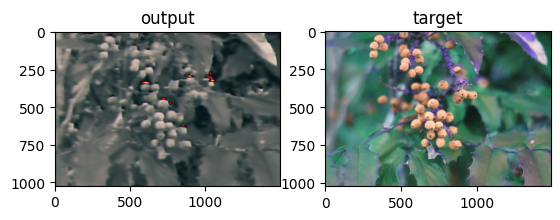

In [ ]:
y1 = (cv.resize(y.reshape((1024, 1024, 3)), (1500, 1024))*255).astype(np.uint8)
t1 = cv.imread(train_bokeh + '/' + str(1) + '.jpg')
plt.subplot(121)
plt.imshow(y1)
plt.title('output')
plt.subplot(122)
plt.imshow(t1)
plt.title('target')

In [ ]:
x_train0 = []
x_train0.append(cv.resize(cv.imread(train_org + '/' + str(26) + '.jpg'), (512, 512))/255)
y = Model_200[6](tf.convert_to_tensor(x_train0)).numpy()

Text(0.5, 1.0, 'target')

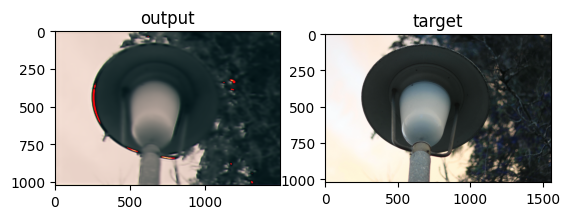

In [ ]:
y1 = (cv.resize(y.reshape((1024, 1024, 3)), (1500, 1024))*255).astype(np.uint8)
t1 = cv.imread(train_bokeh + '/' + str(26) + '.jpg')
plt.subplot(121)
plt.imshow(y1)
plt.title('output')
plt.subplot(122)
plt.imshow(t1)
plt.title('target')

In [ ]:
x_train0 = []
x_train0.append(cv.resize(cv.imread(train_org + '/' + str(99) + '.jpg'), (512, 512))/255)
y = Model_200[6](tf.convert_to_tensor(x_train0)).numpy()

Text(0.5, 1.0, 'target')

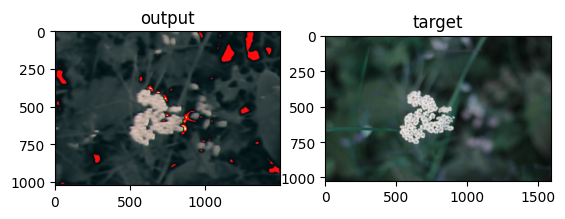

In [ ]:
y1 = (cv.resize(y.reshape((1024, 1024, 3)), (1500, 1024))*255).astype(np.uint8)
t1 = cv.imread(train_bokeh + '/' + str(99) + '.jpg')
plt.subplot(121)
plt.imshow(y1)
plt.title('output')
plt.subplot(122)
plt.imshow(t1)
plt.title('target')

In [ ]:
x_train0 = []
x_train0.append(cv.resize(cv.imread(train_org + '/' + str(104) + '.jpg'), (512, 512))/255)
y = Model_200[6](tf.convert_to_tensor(x_train0)).numpy()

Text(0.5, 1.0, 'target')

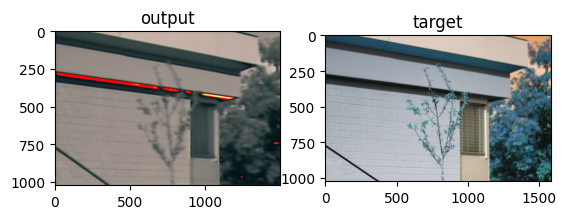

In [ ]:
y1 = (cv.resize(y.reshape((1024, 1024, 3)), (1500, 1024))*255).astype(np.uint8)
t1 = cv.imread(train_bokeh + '/' + str(104) + '.jpg')
plt.subplot(121)
plt.imshow(y1)
plt.title('output')
plt.subplot(122)
plt.imshow(t1)
plt.title('target')

There is not much improvement in the results and further the output images have have developed some red artifects which were not there in the previous iteration of training. Let us proceed in two directions, 
1. Reduce the model complexity and see how the reduced model performs on the same dataset
2. Increase the training dataset further

#### 1. Modifying the baseline PyNet achitecture
The model complexity has been reduced by removing the level 3 which had a total of 323 filters

In [ ]:
def PyNet_seq_reduced(input_shape, instance_norm = True, instance_norm_level3 = False):
    input = Input(input_shape)
    #with tf.compat.v1.variable_scope("generator"):

    space2depth_l0 = tf.nn.space_to_depth(input, 2)

    conv_l3_i1 = conv_multiple(space2depth_l0, 3, num_filters = 32, instance_norm = False)
    pool3 = maxpool(conv_l3_i1, 2)
    conv_l4_i1 = conv_multiple(pool3, 3, num_filters = 64, instance_norm = instance_norm)
    pool4 = maxpool(conv_l4_i1, 2)
    conv_l5_i1 = conv_multiple(pool4, 3, num_filters = 128, instance_norm = instance_norm)
    pool5 = maxpool(conv_l5_i1, 2)
    conv_l6_i1 = conv_multiple(pool5, 3, num_filters = 256, instance_norm = instance_norm)
    pool6 = maxpool(conv_l6_i1, 2)

    conv_l7_i1 = conv_multiple(pool6, 3, num_filters = 512, instance_norm = instance_norm)
    conv_l7_i2 = conv_multiple(conv_l7_i1, 3, num_filters = 512, instance_norm = instance_norm) + conv_l7_i1
    conv_l7_i3 = conv_multiple(conv_l7_i2, 3, num_filters = 512, instance_norm = instance_norm) + conv_l7_i2
    conv_l7_i4 = conv_multiple(conv_l7_i3, 3, num_filters = 512, instance_norm = instance_norm)

    conv_t6a = conv_transpose(conv_l7_i4, 256, 3, 2)      
    conv_t6b = conv_transpose(conv_l7_i4, 256, 3, 2)   

    conv_l7_out = conv_layer(conv_l7_i4, 3, 3, 1, relu=False, instance_norm=False)
    output_l7 = tf.nn.tanh(conv_l7_out) * 0.58 + 0.5

    #---------------------------------------------------------------------------------------------------------------------

    #conv_l6_i2 = tf.concat([conv_l6_i1, conv_t6a], 3)
    conv_l6_i2 = Concatenate()([conv_l6_i1, conv_t6a])
    conv_l6_i3 = conv_multiple(conv_l6_i2, 3, num_filters=256, instance_norm=instance_norm)
    conv_l6_i4 = conv_multiple(conv_l6_i3, 3, num_filters=256, instance_norm=instance_norm) + conv_l6_i3
    conv_l6_i5 = conv_multiple(conv_l6_i4, 3, num_filters=256, instance_norm=instance_norm) + conv_l6_i4
    #conv_l6_i6 = tf.concat([(conv_multiple(conv_l6_i5, 3, num_filters=256, instance_norm=instance_norm), conv_t6b)], 3)
    conv_l6_i6 = Concatenate()([conv_multiple(conv_l6_i5, 3, num_filters=256, instance_norm=instance_norm), conv_t6b])

    conv_l6_i7 = conv_multiple(conv_l6_i6, 3, num_filters=256, instance_norm=instance_norm)

    conv_t5a = conv_transpose(conv_l6_i7, 128, 3, 2)      
    conv_t5b = conv_transpose(conv_l6_i7, 128, 3, 2)      

    conv_l6_out = conv_layer(conv_l6_i7, 3, 3, 1, relu=False, instance_norm=False)
    output_l6 = tf.nn.tanh(conv_l6_out) * 0.58 + 0.5

    # -----------------------------------------------------------------------------------------------------------------------

    #conv_l5_i2 = tf.concat([conv_l5_i1, conv_t5a], 3)
    conv_l5_i2 = Concatenate()([conv_l5_i1, conv_t5a])
    conv_l5_i3 = conv_multiple(conv_l5_i2, 5, num_filters = 128, instance_norm = instance_norm) + conv_l5_i2
    conv_l5_i4 = conv_multiple(conv_l5_i3, 5, num_filters = 128, instance_norm = instance_norm) + conv_l5_i3
    conv_l5_i5 = conv_multiple(conv_l5_i4, 5, num_filters = 128, instance_norm = instance_norm) + conv_l5_i4
    #conv_l5_i6 = tf.concat([conv_multiple(conv_l5_i5, 5, num_filters = 128, instance_norm = instance_norm), conv_l5_i1], 3)
    conv_l5_i6 = Concatenate()([conv_multiple(conv_l5_i5, 5, num_filters = 128, instance_norm = instance_norm), conv_l5_i1])
    #conv_l5_i7 = tf.concat([conv_l5_i6, conv_t5b], 3)
    conv_l5_i7 = Concatenate()([conv_l5_i6, conv_t5b])

    conv_l5_i8 = conv_multiple(conv_l5_i7, 3, num_filters = 128, instance_norm = instance_norm)

    conv_t4a = conv_transpose(conv_l5_i8, 64, 3, 2)
    conv_t4b = conv_transpose(conv_l5_i8, 64, 3, 2)

    conv_l5_out = conv_layer(conv_l5_i8, 3, 3, 1, relu = False, instance_norm = False)
    output_l5 = tf.nn.tanh(conv_l5_out) * 0.58 + 0.5

    # ----------------------------------------------------------------------------------------------------------------------------------

    #conv_l4_i2 = tf.concat([conv_l4_i1, conv_t4a], 3)
    conv_l4_i2 = Concatenate()([conv_l4_i1, conv_t4a])
    #conv_l4_i3 = tf.concat([conv_multiple(conv_l4_i2, 5, num_filters = 64, instance_norm = instance_norm), conv_l4_i1], 3)
    conv_l4_i3 = Concatenate()([conv_multiple(conv_l4_i2, 5, num_filters = 64, instance_norm = instance_norm), conv_l4_i1])

    conv_l4_i4 = conv_multiple(conv_l4_i3, 7, num_filters = 64, instance_norm = instance_norm) + conv_l4_i3
    conv_l4_i5 = conv_multiple(conv_l4_i4, 7, num_filters = 64, instance_norm = instance_norm) + conv_l4_i4
    conv_l4_i6 = conv_multiple(conv_l4_i5, 7, num_filters = 64, instance_norm = instance_norm) + conv_l4_i5
    #conv_l4_i7 = tf.concat([conv_multiple(conv_l4_i6, 7, num_filters = 64, instance_norm = instance_norm), conv_l4_i1], 3)
    conv_l4_i7 = Concatenate()([conv_multiple(conv_l4_i6, 7, num_filters = 64, instance_norm = instance_norm), conv_l4_i1])

    #conv_l4_i8 = tf.concat([conv_multiple(conv_l4_i7, 5, num_filters = 64, instance_norm = instance_norm), conv_t4b], 3)
    conv_l4_i8 = Concatenate()([conv_multiple(conv_l4_i7, 5, num_filters = 64, instance_norm = instance_norm), conv_t4b])
    conv_l4_i9 = conv_multiple(conv_l4_i8, 3, num_filters = 64, instance_norm = instance_norm)

    conv_t3a = conv_transpose(conv_l4_i9, 32, 3, 2)
    conv_t3b = conv_transpose(conv_l4_i9, 32, 3, 2)

    conv_l4_out = conv_layer(conv_l4_i9, 3, 3, 1, relu = False, instance_norm = False)
    output_l4 = tf.nn.tanh(conv_l4_out) * 0.58 + 0.5    

    # ---------------------------------------------------------------------------------------------------------------------

    # ##conv_l3_i2 = tf.concat([conv_l3_i1, conv_t3a], 3)
    # conv_l3_i2 = Concatenate()([conv_l3_i1, conv_t3a])
    # ##conv_l3_i3 = tf.concat([conv_multiple(conv_l3_i2, 5, num_filters = 32, instance_norm = False), conv_l3_i1], 3)
    # conv_l3_i3 = Concatenate()([conv_multiple(conv_l3_i2, 5, num_filters = 32, instance_norm = False), conv_l3_i1])

    # conv_l3_i4 = conv_multiple(conv_l3_i3, 7, num_filters = 32, instance_norm = False)
    # conv_l3_i5 = conv_multiple(conv_l3_i4, 9, num_filters = 32, instance_norm = instance_norm_level3)
    # conv_l3_i6 = conv_multiple(conv_l3_i5, 9, num_filters = 32, instance_norm = instance_norm_level3) + conv_l3_i5
    # conv_l3_i7 = conv_multiple(conv_l3_i6, 9, num_filters = 32, instance_norm = instance_norm_level3) + conv_l3_i6
    # conv_l3_i8 = conv_multiple(conv_l3_i7, 9, num_filters = 32, instance_norm = instance_norm_level3) + conv_l3_i7

    # ##conv_l3_i9 = tf.concat([conv_multiple(conv_l3_i8, 7, num_filters = 32, instance_norm = False), conv_l3_i1], 3)
    # conv_l3_i9 = Concatenate()([conv_multiple(conv_l3_i8, 7, num_filters = 32, instance_norm = False), conv_l3_i1])
    # ##conv_l3_i10 = tf.concat([conv_multiple(conv_l3_i9, 5, num_filters = 32, instance_norm = False), conv_t3b], 3)
    # conv_l3_i10 = Concatenate()([conv_multiple(conv_l3_i9, 5, num_filters = 32, instance_norm = False), conv_t3b])
    # ##conv_l3_i11 = tf.concat([conv_l3_i10, conv_l3_i1], 3)
    # conv_l3_i11 = Concatenate()([conv_l3_i10, conv_l3_i1])
    # conv_l3_i12 = conv_multiple(conv_l3_i11, 3, num_filters = 32, instance_norm = False)

    # conv_l3_out = conv_layer(conv_l3_i12, 3, 3, 1, relu = False, instance_norm = False)
    # output_l3 = tf.nn.tanh(conv_l3_out) * 0.58 + 0.5 

    # --------------------------------------------------------------------------------------------------------------

    conv_l3 = conv_transpose(conv_l4_i9, 8, 3, 2)
    conv_l3_out = conv_layer(conv_l3, 3, 3, 1, relu = False, instance_norm = False)
    output_l3 = tf.nn.tanh(conv_l3_out) * 0.58 + 0.5


    conv_l2 = conv_transpose(conv_l3, 8, 3, 2)
    conv_l2_out = conv_layer(conv_l2, 3, 3, 1, relu = False, instance_norm = False)
    output_l2 = tf.nn.tanh(conv_l2_out) * 0.58 + 0.5

    conv_l1 = conv_transpose(conv_l2_out, 3, 3, 2)
    conv_l1_out = conv_layer(conv_l1, 3, 3, 1, relu = False, instance_norm = False)

    output_l1 = tf.nn.tanh(conv_l1_out) * 0.58 + 0.5
    outputs = [output_l1, output_l2, output_l3, output_l4, output_l5, output_l6, output_l7]
    model = [model7, model6, model5, model4, model3, model2, model1] = [Model(input, output_l7), Model(input, output_l6), Model(input, output_l5), Model(input, output_l4), Model(input, output_l3), Model(input, output_l2), Model(input, output_l1)]
    #return output_l1, output_l2, output_l3, output_l4, output_l5, output_l6, output_l7
    return model

In [ ]:
def trainModelSequrntially_reduced(Model, image_size, batch_size, train_set_size, start, epochs):
    [model7, model6, model5, model4, model2, model1] = Model
    #-------------------training layer 7----------------------------#
    print('##-----Training Layer 7 -----##')
    model7.compile('adam', loss = loss_function)
    trainModel_seq(model7, image_size, batch_size, train_set_size, epochs, start, 7)
    level7_weights = model7.get_weights()
    model7.save(save_dir + 'reduced' + str(train_set_size) + '/model7')

    #-------------------training layer 6----------------------------#
    print('##-----Training Layer 6 -----##')
    model6.weights[0:len(level7_weights)] = level7_weights
    model6.compile('adam', loss = loss_function)
    trainModel_seq(model6, image_size, batch_size, train_set_size, epochs, start, 6)
    level6_weights = model6.get_weights()
    model6.save(save_dir + 'reduced' + str(train_set_size) + '/model6')

    #-------------------training layer 5----------------------------#
    print('##-----Training Layer 5 -----##')
    model5.weights[0:len(level6_weights)] = level6_weights
    model5.compile('adam', loss = loss_function)
    trainModel_seq(model5, image_size, batch_size, train_set_size, epochs, start, 5)
    level5_weights = model5.get_weights()
    model5.save(save_dir + 'reduced' + str(train_set_size) + '/model5')

    #-------------------training layer 4----------------------------#
    print('##-----Training Layer 4 -----##')
    model4.weights[0:len(level5_weights)] = level5_weights
    model4.compile('adam', loss = loss_function)
    trainModel_seq(model4, image_size, batch_size, train_set_size, epochs, start, 4)
    level4_weights = model4.get_weights()
    model4.save(save_dir + 'reduced' + str(train_set_size) + '/model4')

    #-------------------training layer 3----------------------------#
    # print('##-----Training Layer 3 -----##')
    # model3.weights[0:len(level4_weights)] = level4_weights
    # model3.compile('adam', loss = loss_function)
    # trainModel_seq(model3, image_size, batch_size, train_set_size, epochs, start, 3)
    # level3_weights = model3.get_weights()
    # model3.save(save_dir + str(train_set_size) + ' training images ' + '/model3')

    #-------------------training layer 2----------------------------#
    print('##-----Training Layer 2 -----##')
    model2.weights[0:len(level3_weights)] = level3_weights
    model2.compile('adam', loss = loss_function)
    trainModel_seq(model2, image_size, batch_size, train_set_size, epochs, start, 2)
    level2_weights = model2.get_weights()
    model2.save(save_dir + 'reduced' + str(train_set_size) + '/model2')

    #-------------------training layer 1----------------------------#
    print('##-----Training Layer 1 -----##')
    model1.weights[0:len(level2_weights)] = level2_weights
    model1.compile('adam', loss = loss1)
    trainModel_seq(model1, image_size, batch_size, train_set_size, epochs, start, 1)
    level1_weights = model1.get_weights()
    model1.save(save_dir + 'reduced' + str(train_set_size) + '/model1')

In [ ]:
Model_reduced_25 = PyNet_seq_reduced((512, 512, 3))

In [ ]:
trainModelSequrntially(Model_reduced_25, image_size=(1024, 1024, 3), batch_size = 1, train_set_size = 25, start = 0, epochs = 10)

##-----Training Layer 7 -----##
--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 1.1829
Epoch 2/10
1/1 [==============================] - 0s 52ms/step - loss: 1.3927
Epoch 3/10
1/1 [==============================] - 0s 52ms/step - loss: 1.2376
Epoch 4/10
1/1 [==============================] - 0s 54ms/step - loss: 1.1512
Epoch 5/10
1/1 [==============================] - 0s 52ms/step - loss: 1.1104
Epoch 6/10
1/1 [==============================] - 0s 53ms/step - loss: 0.9454
Epoch 7/10
1/1 [==============================] - 0s 51ms/step - loss: 0.7740
Epoch 8/10
1/1 [==============================] - 0s 41ms/step - loss: 0.9538
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 0.6674
Epoch 10/10
1/1 [==============================] - 0s 41ms/step - loss: 0.7601
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 0s 45ms/step - loss: 0.9181
Epoch 2/10
1/1 [===================

##-----Training Layer 6 -----##
--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 12s 12s/step - loss: 1.0737
Epoch 2/10
1/1 [==============================] - 0s 78ms/step - loss: 0.9869
Epoch 3/10
1/1 [==============================] - 0s 75ms/step - loss: 1.0006
Epoch 4/10
1/1 [==============================] - 0s 72ms/step - loss: 0.8872
Epoch 5/10
1/1 [==============================] - 0s 67ms/step - loss: 0.8142
Epoch 6/10
1/1 [==============================] - 0s 63ms/step - loss: 0.5693
Epoch 7/10
1/1 [==============================] - 0s 55ms/step - loss: 0.6441
Epoch 8/10
1/1 [==============================] - 0s 56ms/step - loss: 0.5101
Epoch 9/10
1/1 [==============================] - 0s 57ms/step - loss: 0.6975
Epoch 10/10
1/1 [==============================] - 0s 55ms/step - loss: 0.5456
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 0s 76ms/step - loss: 0.8277
Epoch 2/10
1/1 [=================

##-----Training Layer 5 -----##
--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 19s 19s/step - loss: 0.9802
Epoch 2/10
1/1 [==============================] - 0s 140ms/step - loss: 1.0101
Epoch 3/10
1/1 [==============================] - 0s 109ms/step - loss: 1.3161
Epoch 4/10
1/1 [==============================] - 0s 87ms/step - loss: 0.9103
Epoch 5/10
1/1 [==============================] - 0s 87ms/step - loss: 0.8638
Epoch 6/10
1/1 [==============================] - 0s 91ms/step - loss: 0.7945
Epoch 7/10
1/1 [==============================] - 0s 85ms/step - loss: 0.7927
Epoch 8/10
1/1 [==============================] - 0s 88ms/step - loss: 0.7230
Epoch 9/10
1/1 [==============================] - 0s 85ms/step - loss: 0.6806
Epoch 10/10
1/1 [==============================] - 0s 84ms/step - loss: 0.6031
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 0s 140ms/step - loss: 0.7527
Epoch 2/10
1/1 [==============

##-----Training Layer 4 -----##
--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 33s 33s/step - loss: 0.8547
Epoch 2/10
1/1 [==============================] - 0s 255ms/step - loss: 0.9106
Epoch 3/10
1/1 [==============================] - 0s 182ms/step - loss: 0.8112
Epoch 4/10
1/1 [==============================] - 0s 164ms/step - loss: 1.0243
Epoch 5/10
1/1 [==============================] - 0s 168ms/step - loss: 0.8078
Epoch 6/10
1/1 [==============================] - 0s 169ms/step - loss: 0.8146
Epoch 7/10
1/1 [==============================] - 0s 169ms/step - loss: 0.8073
Epoch 8/10
1/1 [==============================] - 0s 167ms/step - loss: 0.7877
Epoch 9/10
1/1 [==============================] - 0s 166ms/step - loss: 0.7524
Epoch 10/10
1/1 [==============================] - 0s 164ms/step - loss: 0.8012
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 0s 171ms/step - loss: 0.8214
Epoch 2/10
1/1 [=======

##-----Training Layer 3 -----##
--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 33s 33s/step - loss: 1.0816
Epoch 2/10
1/1 [==============================] - 0s 280ms/step - loss: 0.8842
Epoch 3/10
1/1 [==============================] - 0s 164ms/step - loss: 0.7723
Epoch 4/10
1/1 [==============================] - 0s 163ms/step - loss: 0.7341
Epoch 5/10
1/1 [==============================] - 0s 163ms/step - loss: 0.7243
Epoch 6/10
1/1 [==============================] - 0s 171ms/step - loss: 0.7227
Epoch 7/10
1/1 [==============================] - 0s 166ms/step - loss: 0.7210
Epoch 8/10
1/1 [==============================] - 0s 169ms/step - loss: 0.7187
Epoch 9/10
1/1 [==============================] - 0s 163ms/step - loss: 0.7167
Epoch 10/10
1/1 [==============================] - 0s 163ms/step - loss: 0.7157
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 0s 167ms/step - loss: 0.7418
Epoch 2/10
1/1 [=======

##-----Training Layer 2 -----##
--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 35s 35s/step - loss: 1.0121
Epoch 2/10
1/1 [==============================] - 0s 315ms/step - loss: 0.7902
Epoch 3/10
1/1 [==============================] - 0s 178ms/step - loss: 0.7230
Epoch 4/10
1/1 [==============================] - 0s 179ms/step - loss: 0.6952
Epoch 5/10
1/1 [==============================] - 0s 177ms/step - loss: 0.6847
Epoch 6/10
1/1 [==============================] - 0s 174ms/step - loss: 0.6756
Epoch 7/10
1/1 [==============================] - 0s 167ms/step - loss: 0.6672
Epoch 8/10
1/1 [==============================] - 0s 173ms/step - loss: 0.6618
Epoch 9/10
1/1 [==============================] - 0s 174ms/step - loss: 0.6583
Epoch 10/10
1/1 [==============================] - 0s 169ms/step - loss: 0.6557
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 0s 312ms/step - loss: 0.5811
Epoch 2/10
1/1 [=======

##-----Training Layer 1 -----##
--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 34s 34s/step - loss: 0.2709
Epoch 2/10
1/1 [==============================] - 0s 279ms/step - loss: 0.2628
Epoch 3/10
1/1 [==============================] - 0s 190ms/step - loss: 0.2580
Epoch 4/10
1/1 [==============================] - 0s 177ms/step - loss: 0.2534
Epoch 5/10
1/1 [==============================] - 0s 177ms/step - loss: 0.2506
Epoch 6/10
1/1 [==============================] - 0s 179ms/step - loss: 0.2483
Epoch 7/10
1/1 [==============================] - 0s 172ms/step - loss: 0.2463
Epoch 8/10
1/1 [==============================] - 0s 179ms/step - loss: 0.2452
Epoch 9/10
1/1 [==============================] - 0s 173ms/step - loss: 0.2439
Epoch 10/10
1/1 [==============================] - 0s 174ms/step - loss: 0.2428
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 0s 185ms/step - loss: 0.1505
Epoch 2/10
1/1 [=======

In [ ]:
x_train0 = []
x_train0.append(cv.resize(cv.imread(train_org + '/' + str(1) + '.jpg'), (512, 512))/255)
y = Model_reduced_25[6](tf.convert_to_tensor(x_train0)).numpy()

Text(0.5, 1.0, 'target')

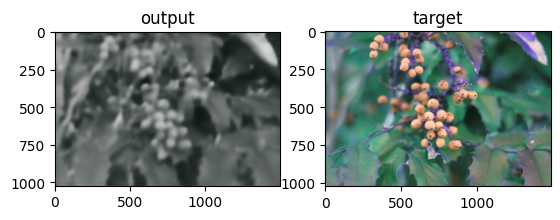

In [ ]:
y1 = (cv.resize(y.reshape((1024, 1024, 3)), (1500, 1024))*255).astype(np.uint8)
t1 = cv.imread(train_bokeh + '/' + str(1) + '.jpg')
plt.subplot(121)
plt.imshow(y1)
plt.title('output')
plt.subplot(122)
plt.imshow(t1)
plt.title('target')

In [ ]:
x_train0 = []
x_train0.append(cv.resize(cv.imread(train_org + '/' + str(26) + '.jpg'), (512, 512))/255)
y = Model_reduced_25[6](tf.convert_to_tensor(x_train0)).numpy()

Text(0.5, 1.0, 'target')

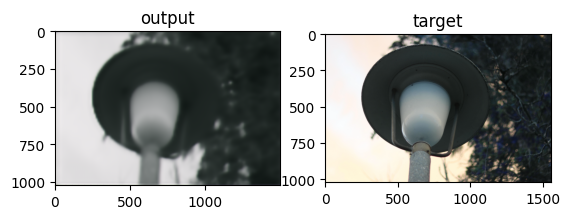

In [ ]:
y1 = (cv.resize(y.reshape((1024, 1024, 3)), (1500, 1024))*255).astype(np.uint8)
t1 = cv.imread(train_bokeh + '/' + str(26) + '.jpg')
plt.subplot(121)
plt.imshow(y1)
plt.title('output')
plt.subplot(122)
plt.imshow(t1)
plt.title('target')

In [ ]:
x_train0 = []
x_train0.append(cv.resize(cv.imread(train_org + '/' + str(99) + '.jpg'), (512, 512))/255)
y = Model_reduced_25[6](tf.convert_to_tensor(x_train0)).numpy()

Text(0.5, 1.0, 'target')

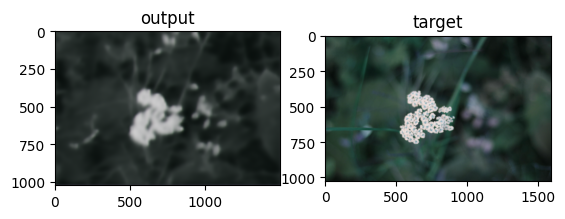

In [ ]:
y1 = (cv.resize(y.reshape((1024, 1024, 3)), (1500, 1024))*255).astype(np.uint8)
t1 = cv.imread(train_bokeh + '/' + str(99) + '.jpg')
plt.subplot(121)
plt.imshow(y1)
plt.title('output')
plt.subplot(122)
plt.imshow(t1)
plt.title('target')

In [ ]:
x_train0 = []
x_train0.append(cv.resize(cv.imread(train_org + '/' + str(104) + '.jpg'), (512, 512))/255)
y = Model_reduced_25[6](tf.convert_to_tensor(x_train0)).numpy()

Text(0.5, 1.0, 'target')

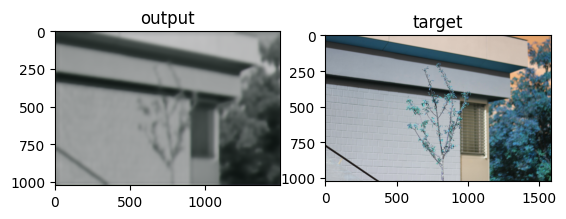

In [ ]:
y1 = (cv.resize(y.reshape((1024, 1024, 3)), (1500, 1024))*255).astype(np.uint8)
t1 = cv.imread(train_bokeh + '/' + str(104) + '.jpg')
plt.subplot(121)
plt.imshow(y1)
plt.title('output')
plt.subplot(122)
plt.imshow(t1)
plt.title('target')

The four results that are displayed above suggest us that reducing model complexity is not the solution to the probelem. In fact reducing model complexity has actually has made the results worse

#### 2. Sequential training with 400 Images

In [ ]:
image_size = ((1024, 1024, 3))
Model_400 = PyNet_seq2((512, 512, 3))
trainModelSequrntially(Model_400, image_size, batch_size = 1, train_set_size = 400, start = 0, epochs = 10)

Streaming output truncated to the last 5000 lines.
Epoch 10/10
1/1 [==============================] - 0s 39ms/step - loss: 0.1665
--------------batch  163 --------------
Epoch 1/10
1/1 [==============================] - 0s 62ms/step - loss: 0.7416
Epoch 2/10
1/1 [==============================] - 0s 56ms/step - loss: 0.6880
Epoch 3/10
1/1 [==============================] - 0s 56ms/step - loss: 0.6209
Epoch 4/10
1/1 [==============================] - 0s 62ms/step - loss: 0.5658
Epoch 5/10
1/1 [==============================] - 0s 51ms/step - loss: 0.5069
Epoch 6/10
1/1 [==============================] - 0s 45ms/step - loss: 0.4642
Epoch 7/10
1/1 [==============================] - 0s 42ms/step - loss: 0.4340
Epoch 8/10
1/1 [==============================] - 0s 46ms/step - loss: 0.4649
Epoch 9/10
1/1 [==============================] - 0s 40ms/step - loss: 0.3870
Epoch 10/10
1/1 [==============================] - 0s 43ms/step - loss: 0.3777
--------------batch  164 --------------
Epoch 1/1

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 49ms/step - loss: 0.4931
--------------batch  163 --------------
Epoch 1/10
1/1 [==============================] - 0s 64ms/step - loss: 0.6511
Epoch 2/10
1/1 [==============================] - 0s 59ms/step - loss: 0.6382
Epoch 3/10
1/1 [==============================] - 0s 51ms/step - loss: 0.6303
Epoch 4/10
1/1 [==============================] - 0s 52ms/step - loss: 0.6201
Epoch 5/10
1/1 [==============================] - 0s 49ms/step - loss: 0.6233
Epoch 6/10
1/1 [==============================] - 0s 54ms/step - loss: 0.6048
Epoch 7/10
1/1 [==============================] - 0s 52ms/step - loss: 0.5978
Epoch 8/10
1/1 [==============================] - 0s 52ms/step - loss: 0.5879
Epoch 9/10
1/1 [==============================] - 0s 54ms/step - loss: 0.5808
Epoch 10/10
1/1 [==============================] - 0s 56ms/step - loss: 0.5726
--------------batch  164 --------------
Epoch 1/10
1/1 [=====

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 81ms/step - loss: 0.2800
--------------batch  163 --------------
Epoch 1/10
1/1 [==============================] - 0s 88ms/step - loss: 0.4476
Epoch 2/10
1/1 [==============================] - 0s 86ms/step - loss: 0.4321
Epoch 3/10
1/1 [==============================] - 0s 81ms/step - loss: 0.4137
Epoch 4/10
1/1 [==============================] - 0s 83ms/step - loss: 0.3962
Epoch 5/10
1/1 [==============================] - 0s 87ms/step - loss: 0.3809
Epoch 6/10
1/1 [==============================] - 0s 84ms/step - loss: 0.3687
Epoch 7/10
1/1 [==============================] - 0s 87ms/step - loss: 0.3585
Epoch 8/10
1/1 [==============================] - 0s 85ms/step - loss: 0.3501
Epoch 9/10
1/1 [==============================] - 0s 86ms/step - loss: 0.3441
Epoch 10/10
1/1 [==============================] - 0s 81ms/step - loss: 0.3398
--------------batch  164 --------------
Epoch 1/10
1/1 [=====

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 169ms/step - loss: 0.2888
--------------batch  163 --------------
Epoch 1/10
1/1 [==============================] - 0s 177ms/step - loss: 0.4452
Epoch 2/10
1/1 [==============================] - 0s 174ms/step - loss: 0.4381
Epoch 3/10
1/1 [==============================] - 0s 174ms/step - loss: 0.4230
Epoch 4/10
1/1 [==============================] - 0s 170ms/step - loss: 0.4081
Epoch 5/10
1/1 [==============================] - 0s 176ms/step - loss: 0.3935
Epoch 6/10
1/1 [==============================] - 0s 169ms/step - loss: 0.3788
Epoch 7/10
1/1 [==============================] - 0s 166ms/step - loss: 0.3645
Epoch 8/10
1/1 [==============================] - 0s 173ms/step - loss: 0.3516
Epoch 9/10
1/1 [==============================] - 0s 167ms/step - loss: 0.3416
Epoch 10/10
1/1 [==============================] - 0s 166ms/step - loss: 0.3355
--------------batch  164 --------------
Epoch 1/10

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 403ms/step - loss: 0.3281
--------------batch  163 --------------
Epoch 1/10
1/1 [==============================] - 0s 408ms/step - loss: 0.4095
Epoch 2/10
1/1 [==============================] - 0s 403ms/step - loss: 0.3807
Epoch 3/10
1/1 [==============================] - 0s 406ms/step - loss: 0.3725
Epoch 4/10
1/1 [==============================] - 0s 402ms/step - loss: 0.3702
Epoch 5/10
1/1 [==============================] - 0s 402ms/step - loss: 0.3682
Epoch 6/10
1/1 [==============================] - 0s 404ms/step - loss: 0.3656
Epoch 7/10
1/1 [==============================] - 0s 399ms/step - loss: 0.3625
Epoch 8/10
1/1 [==============================] - 0s 400ms/step - loss: 0.3589
Epoch 9/10
1/1 [==============================] - 0s 400ms/step - loss: 0.3552
Epoch 10/10
1/1 [==============================] - 0s 401ms/step - loss: 0.3515
--------------batch  164 --------------
Epoch 1/10

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 411ms/step - loss: 0.3446
--------------batch  163 --------------
Epoch 1/10
1/1 [==============================] - 0s 452ms/step - loss: 0.3230
Epoch 2/10
1/1 [==============================] - 0s 405ms/step - loss: 0.3234
Epoch 3/10
1/1 [==============================] - 0s 410ms/step - loss: 0.3227
Epoch 4/10
1/1 [==============================] - 0s 409ms/step - loss: 0.3213
Epoch 5/10
1/1 [==============================] - 0s 415ms/step - loss: 0.3193
Epoch 6/10
1/1 [==============================] - 0s 406ms/step - loss: 0.3170
Epoch 7/10
1/1 [==============================] - 0s 406ms/step - loss: 0.3145
Epoch 8/10
1/1 [==============================] - 0s 410ms/step - loss: 0.3119
Epoch 9/10
1/1 [==============================] - 0s 412ms/step - loss: 0.3093
Epoch 10/10
1/1 [==============================] - 0s 410ms/step - loss: 0.3067
--------------batch  164 --------------
Epoch 1/10

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 414ms/step - loss: 0.0705
--------------batch  163 --------------
Epoch 1/10
1/1 [==============================] - 1s 554ms/step - loss: 0.0846
Epoch 2/10
1/1 [==============================] - 0s 419ms/step - loss: 0.0841
Epoch 3/10
1/1 [==============================] - 0s 411ms/step - loss: 0.0828
Epoch 4/10
1/1 [==============================] - 0s 420ms/step - loss: 0.0816
Epoch 5/10
1/1 [==============================] - 0s 422ms/step - loss: 0.0812
Epoch 6/10
1/1 [==============================] - 0s 420ms/step - loss: 0.0810
Epoch 7/10
1/1 [==============================] - 0s 431ms/step - loss: 0.0800
Epoch 8/10
1/1 [==============================] - 0s 419ms/step - loss: 0.0788
Epoch 9/10
1/1 [==============================] - 0s 423ms/step - loss: 0.0780
Epoch 10/10
1/1 [==============================] - 0s 429ms/step - loss: 0.0776
--------------batch  164 --------------
Epoch 1/10

In [ ]:
x_train0 = []
x_train0.append(cv.resize(cv.imread(train_org + '/' + str(1) + '.jpg'), (512, 512))/255)
Model_400_saved = tf.keras.models.load_model('/content/drive/MyDrive/Bokeh-dataset/saved_models400/model1', custom_objects = {'loss_function' : loss1})
y = Model_400_saved(tf.convert_to_tensor(x_train0)).numpy()

Text(0.5, 1.0, 'target')

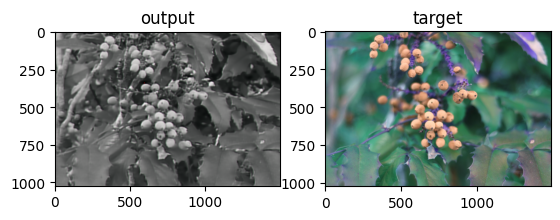

In [ ]:
y1 = (cv.resize(y.reshape((1024, 1024, 3)), (1500, 1024))*255).astype(np.uint8)
t1 = cv.imread(train_bokeh + '/' + str(1) + '.jpg')
#plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(y1)
plt.title('output')
plt.subplot(122)
plt.imshow(t1)
plt.title('target')

In [ ]:
x_train0 = []
x_train0.append(cv.resize(cv.imread(train_org + '/' + str(26) + '.jpg'), (512, 512))/255)
y = Model_400_saved(tf.convert_to_tensor(x_train0)).numpy()

Text(0.5, 1.0, 'target')

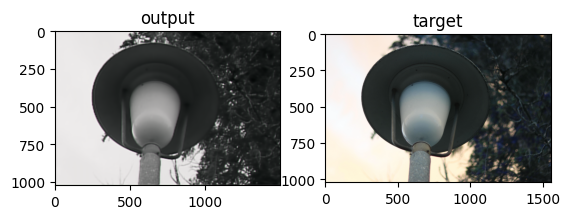

In [ ]:
y1 = (cv.resize(y.reshape((1024, 1024, 3)), (1500, 1024))*255).astype(np.uint8)
t1 = cv.imread(train_bokeh + '/' + str(26) + '.jpg')
plt.subplot(121)
plt.imshow(y1)
plt.title('output')
plt.subplot(122)
plt.imshow(t1)
plt.title('target')

In [ ]:
x_train0 = []
x_train0.append(cv.resize(cv.imread(train_org + '/' + str(99) + '.jpg'), (512, 512))/255)
y = Model_400_saved(tf.convert_to_tensor(x_train0)).numpy()

Text(0.5, 1.0, 'target')

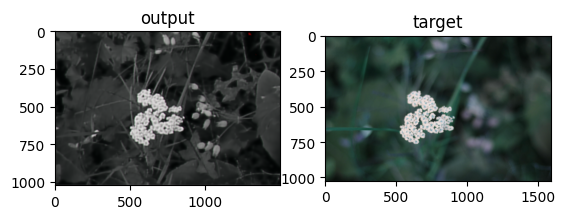

In [ ]:
y1 = (cv.resize(y.reshape((1024, 1024, 3)), (1500, 1024))*255).astype(np.uint8)
t1 = cv.imread(train_bokeh + '/' + str(99) + '.jpg')
plt.subplot(121)
plt.imshow(y1)
plt.title('output')
plt.subplot(122)
plt.imshow(t1)
plt.title('target')

In [ ]:
x_train0 = []
x_train0.append(cv.resize(cv.imread(train_org + '/' + str(104) + '.jpg'), (512, 512))/255)
y = Model_400_saved(tf.convert_to_tensor(x_train0)).numpy()

Text(0.5, 1.0, 'target')

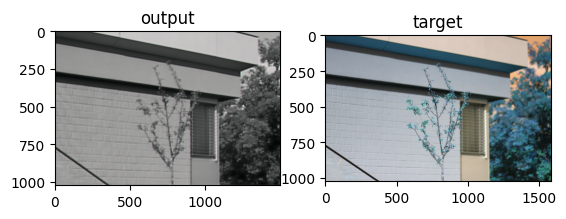

In [ ]:
y1 = (cv.resize(y.reshape((1024, 1024, 3)), (1500, 1024))*255).astype(np.uint8)
t1 = cv.imread(train_bokeh + '/' + str(104) + '.jpg')
plt.subplot(121)
plt.imshow(y1)
plt.title('output')
plt.subplot(122)
plt.imshow(t1)
plt.title('target')

The four output images shown above show a significant improvement from the model trained with just 200 images. The red artifects have gone and also the central object is a little more clear than the rest of the image as in the street-lamp image(image 2). Although the output images are still lacking color information, increasing dataset seems promising

#### Sequential training with 800 Images

In [ ]:
image_size = ((1024, 1024, 3))
trainModelSequrntially(Model_800, image_size, batch_size = 1, train_set_size = 800, start = 0, epochs = 10)

##-----Training Layer 7 -----##
--------------batch  1 --------------
Epoch 1/10
1/1 [==============================] - 10s 10s/step - loss: 1.1792
Epoch 2/10
1/1 [==============================] - 0s 41ms/step - loss: 1.1913
Epoch 3/10
1/1 [==============================] - 0s 44ms/step - loss: 1.0972
Epoch 4/10
1/1 [==============================] - 0s 42ms/step - loss: 1.1235
Epoch 5/10
1/1 [==============================] - 0s 44ms/step - loss: 1.1070
Epoch 6/10
1/1 [==============================] - 0s 37ms/step - loss: 1.1557
Epoch 7/10
1/1 [==============================] - 0s 44ms/step - loss: 1.1473
Epoch 8/10
1/1 [==============================] - 0s 45ms/step - loss: 1.1234
Epoch 9/10
1/1 [==============================] - 0s 41ms/step - loss: 1.0508
Epoch 10/10
1/1 [==============================] - 0s 42ms/step - loss: 0.8195
--------------batch  2 --------------
Epoch 1/10
1/1 [==============================] - 0s 43ms/step - loss: 0.9500
Epoch 2/10
1/1 [=================

error: ignored

Training with 800 images could not be completed in time due to unavalibility of enough computational resources

##### Conclusion
The project is partially complete. I did not have access to any gpu locally I used google colab and since there is a limit on use time in google colab I could not get enough computational resources. The model should be trained with a larger dataset and this will enhance the result

##### References
1. https://github.com/aiff22/PyNET-Bokeh - Master project repository of the research paper which I have implemented. Motivation of the code and high level idea of the PyNet function is taken from this source
2. https://www.tensorflow.org/api_docs - Official tensorflow api documentation. I reffered to to this resource while using the tensorflow library functions like Conv2D, ConvTranspose2D, etc.
3. https://stackoverflow.com/questions/3451111/unzipping-files-in-python - This is a stackoverflow thread. I used this to write code for unzipping the dataset in pyhton notebook
4. https://chat.openai.com - ChatGPT. I used chatgpt to clear my doubts about understanding concepts that could not done from the above resources. I used it to understand how tf.sessions work, etc

##### Decleration
This project is completly is done by me\
  Madan Y N\
  200070040